##### DATA: https://www.kaggle.com/datasets/harshvardhan21/dna-sequence-prediction

In [1]:
# DNA Sequence Classification Pipeline

# 📌 Part 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix,make_scorer
from sklearn.model_selection import cross_validate

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, Attention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import joblib
import pickle

In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [3]:
# 📌 Part 2: Load Dataset
train_df = pd.read_csv("DATA/train.csv")
val_df = pd.read_csv("DATA/validation.csv")
test_df = pd.read_csv("DATA/test.csv")

train_df = train_df.drop(columns=['Unnamed: 0'], errors='ignore')
val_df = val_df.drop(columns=['Unnamed: 0'], errors='ignore')
test_df = test_df.drop(columns=['Unnamed: 0'], errors='ignore')


In [4]:
# 📌 Part 3: Encode Labels and Tokenize Sequences using 4-mers
def kmer_tokenizer(sequence, k=4):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def build_vocab(sequences, k):
    vocab = set()
    for seq in sequences:
        vocab.update(kmer_tokenizer(seq, k))
    vocab = sorted(vocab)
    return {kmer: idx + 1 for idx, kmer in enumerate(vocab)}  # reserve 0 for padding

k = 4
all_sequences = pd.concat([train_df['NucleotideSequence'], val_df['NucleotideSequence'], test_df['NucleotideSequence']])
vocab = build_vocab(all_sequences, k)
vocab_size = len(vocab) + 1

def encode_sequence(seq, k, vocab):
    tokens = kmer_tokenizer(seq, k)
    return [vocab.get(token, 0) for token in tokens]

X_train = train_df['NucleotideSequence'].apply(lambda x: encode_sequence(x, k, vocab)).tolist()
X_val = val_df['NucleotideSequence'].apply(lambda x: encode_sequence(x, k, vocab)).tolist()
X_test = test_df['NucleotideSequence'].apply(lambda x: encode_sequence(x, k, vocab)).tolist()

# Pad Sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_val), max(len(seq) for seq in X_test))
X_train_pad = pad_sequences(X_train, maxlen=max_len)
X_val_pad = pad_sequences(X_val, maxlen=max_len)
X_test_pad = pad_sequences(X_test, maxlen=max_len)

# Encode Labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(train_df['GeneType'])
y_val_enc = label_encoder.transform(val_df['GeneType'])
y_test_enc = label_encoder.transform(test_df['GeneType'])

num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_enc, num_classes)
y_val_cat = to_categorical(y_val_enc, num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes)


In [5]:
# 📌 Part 4: Baseline Classifier Comparison

X_flat = [np.mean(x) for x in X_train_pad]  # crude flattening for baseline models
y = y_train_enc

models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Naive Bayes": MultinomialNB()
}


In [7]:
# 📌 Part 5: Deep Learning Model (CNN + BiLSTM + Attention)
def build_model(vocab_size, max_len, num_classes):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Attention()([x, x])
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

model = build_model(vocab_size, max_len, num_classes)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 999)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 999, 128)     49408       ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 995, 128)     82048       ['embedding[0][0]']              
                                                                                                  
 bidirectional (Bidirectional)  (None, 995, 128)     98816       ['conv1d[0][0]']                 
                                                                                              

In [8]:
# 📌 Part 6: Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
177/177 [==============================] - 46s 233ms/step - loss: 1.3318 - accuracy: 0.5122 - val_loss: 0.9695 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 2/100
177/177 [==============================] - 40s 228ms/step - loss: 0.9675 - accuracy: 0.6646 - val_loss: 0.8163 - val_accuracy: 0.7160 - lr: 0.0010
Epoch 3/100
177/177 [==============================] - 40s 228ms/step - loss: 0.8718 - accuracy: 0.6998 - val_loss: 0.7582 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 4/100
177/177 [==============================] - 40s 227ms/step - loss: 0.7948 - accuracy: 0.7261 - val_loss: 0.6850 - val_accuracy: 0.7612 - lr: 0.0010
Epoch 5/100
177/177 [==============================] - 41s 231ms/step - loss: 0.7108 - accuracy: 0.7555 - val_loss: 0.6363 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 6/100
177/177 [==============================] - 40s 227ms/step - loss: 0.6456 - accuracy: 0.7744 - val_loss: 0.5938 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 7/100
177/177 [=========================

In [9]:
# 📌 Part 7: Evaluation
y_pred_proba = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Test Accuracy: {acc:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-score: {f1:.4f}")

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


261/261 [==============================] - 19s 70ms/step
Test Accuracy: 0.9817
Macro Precision: 0.8737
Macro Recall: 0.8601
Macro F1-score: 0.8666
                   precision    recall  f1-score   support

BIOLOGICAL_REGION       0.99      0.99      0.99      2651
            OTHER       0.99      0.98      0.99       133
   PROTEIN_CODING       0.98      0.89      0.93       184
           PSEUDO       0.98      0.99      0.99      3800
            ncRNA       0.97      0.96      0.96       894
             rRNA       0.99      0.99      0.99        72
            scRNA       0.00      0.00      0.00         1
            snRNA       0.89      0.84      0.86        38
           snoRNA       0.96      0.98      0.97       405
             tRNA       0.99      0.98      0.99       148

         accuracy                           0.98      8326
        macro avg       0.87      0.86      0.87      8326
     weighted avg       0.98      0.98      0.98      8326



c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

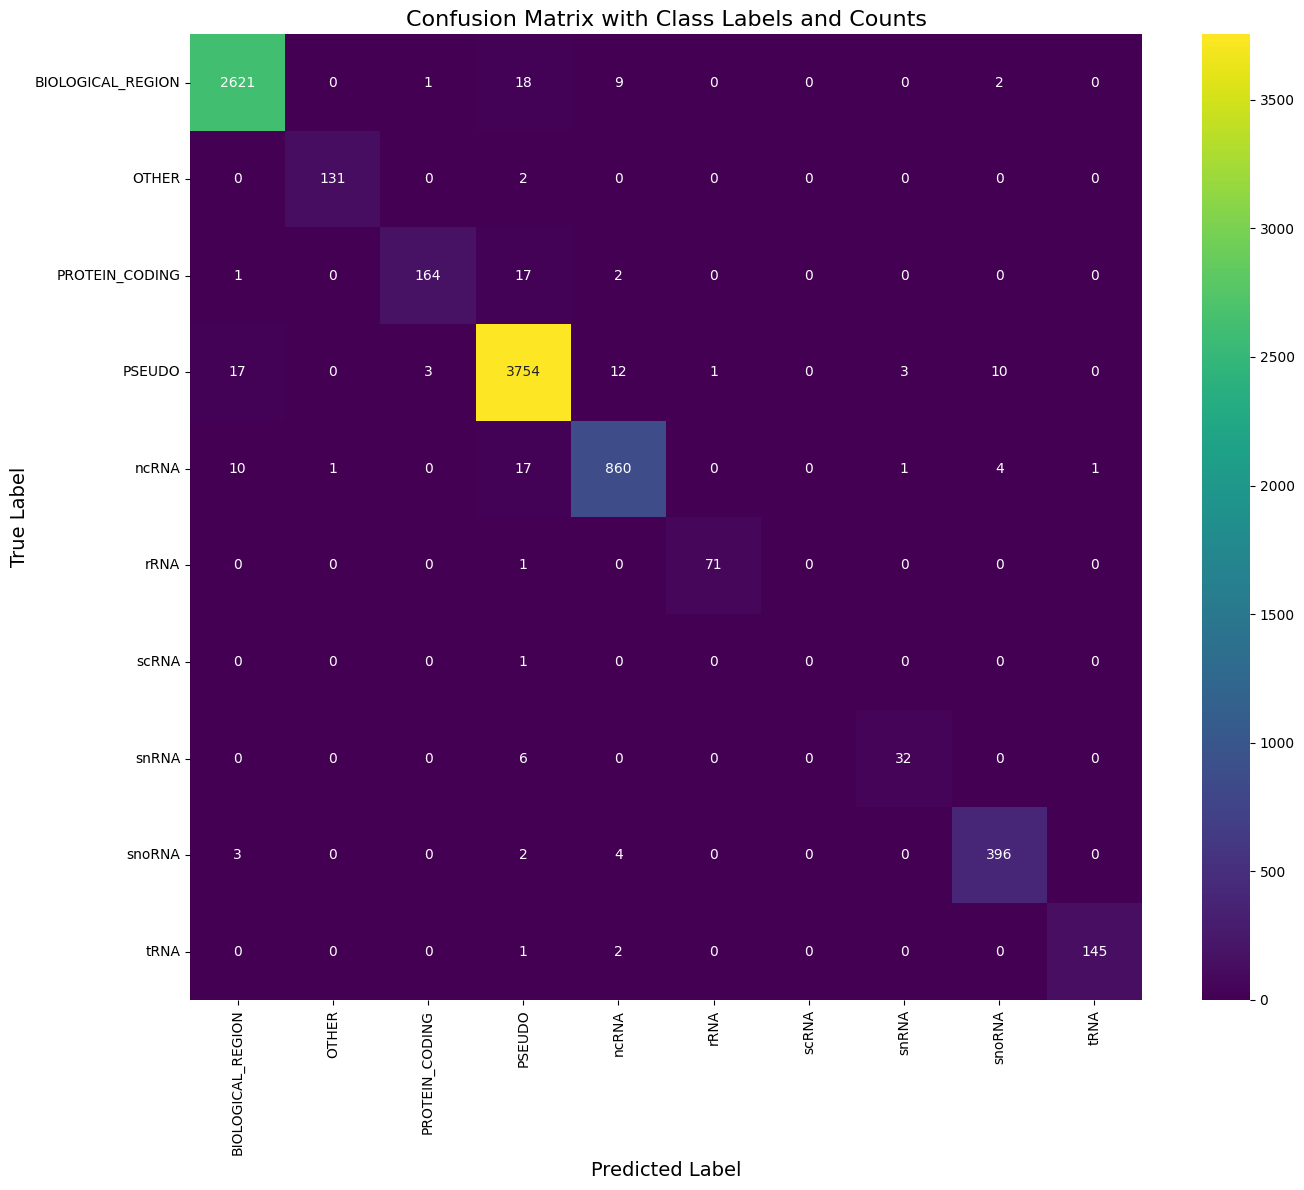

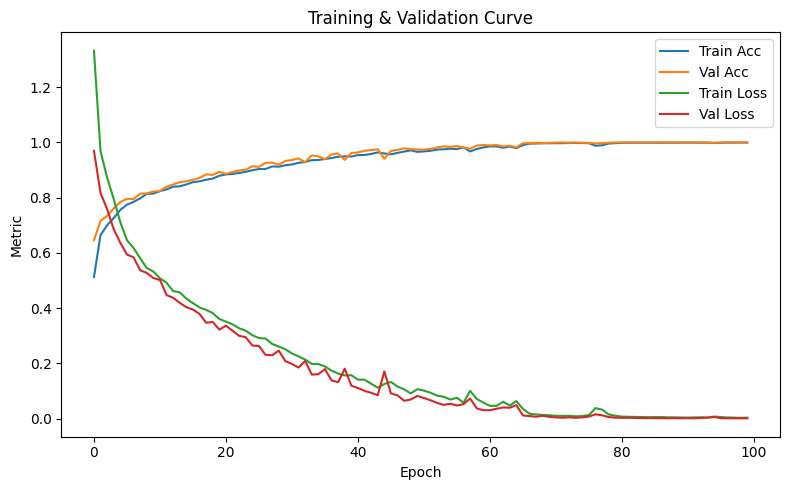

In [29]:
# 📌 Part 8: Visualizations

# Confusion Matrix


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get decoded class labels
class_names = label_encoder.inverse_transform(np.unique(y_true))

# Plot heatmap with counts and labels
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix with Class Labels and Counts', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()




# Training Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Training & Validation Curve")
plt.tight_layout()
plt.show()

In [11]:
# 📌 Part 9: Save Model and Artifacts
model.save("dna_classifier_model.h5")
with open("dna_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
with open("dna_vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)


In [64]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


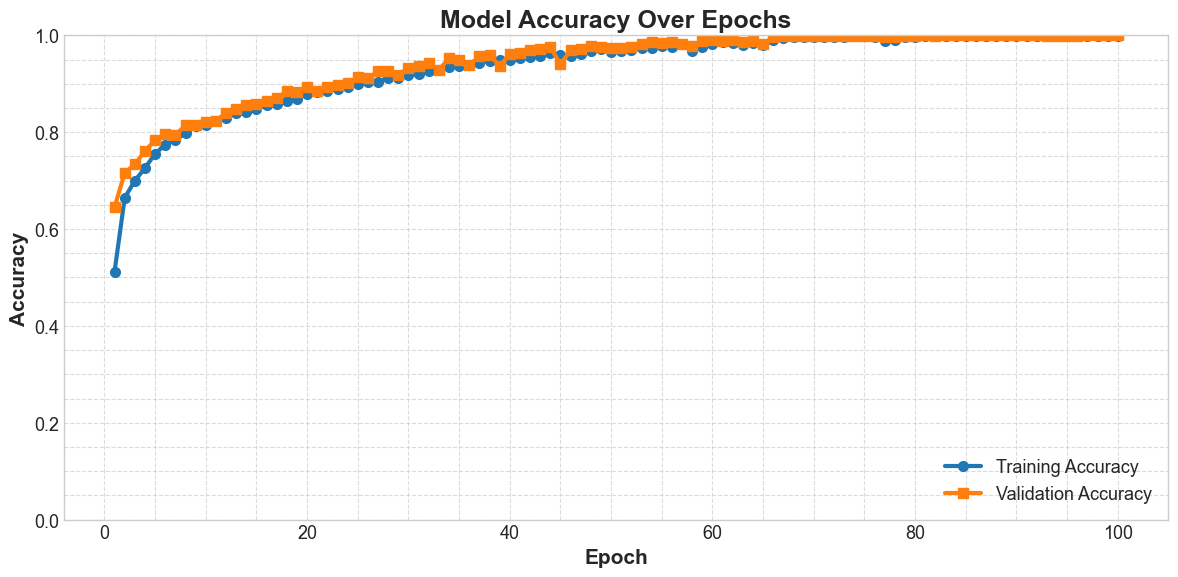

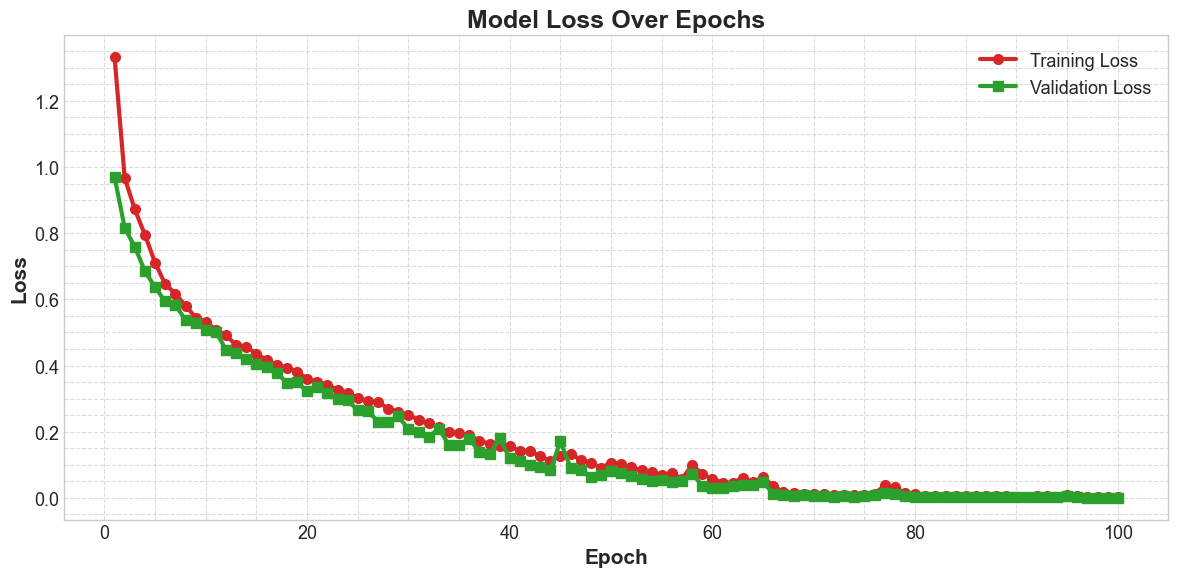

In [66]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 15,
    'legend.fontsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'grid.linewidth': 0.8,
    'grid.alpha': 0.7,
})

# Extract data
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Accuracy Plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='#1f77b4', linewidth=3, marker='o', markersize=7)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='#ff7f0e', linewidth=3, marker='s', markersize=7)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # accuracy between 0 and 1
plt.legend(loc='lower right', shadow=True, fancybox=True)
plt.grid(True, linestyle='--', which='both', axis='both')
plt.minorticks_on()
plt.tight_layout()
plt.show()

# Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='#d62728', linewidth=3, marker='o', markersize=7)
plt.plot(epochs, val_loss, label='Validation Loss', color='#2ca02c', linewidth=3, marker='s', markersize=7)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', shadow=True, fancybox=True)
plt.grid(True, linestyle='--', which='both', axis='both')
plt.minorticks_on()
plt.tight_layout()
plt.show()


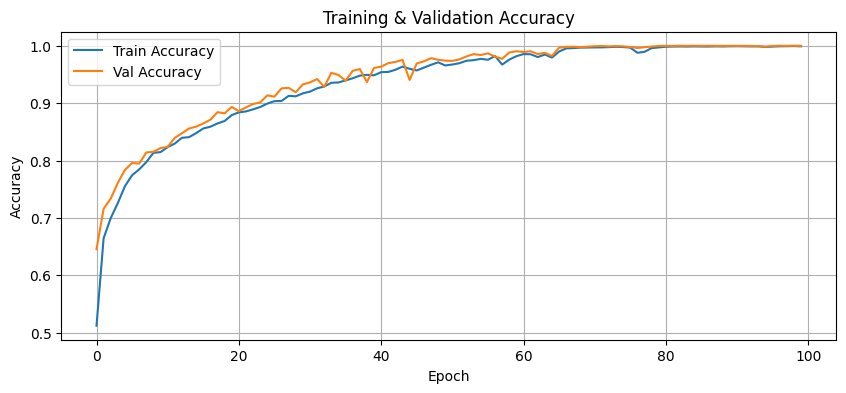

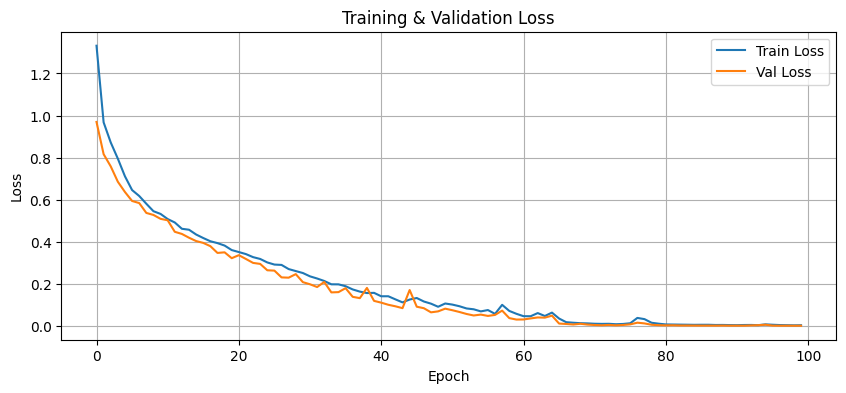

In [12]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


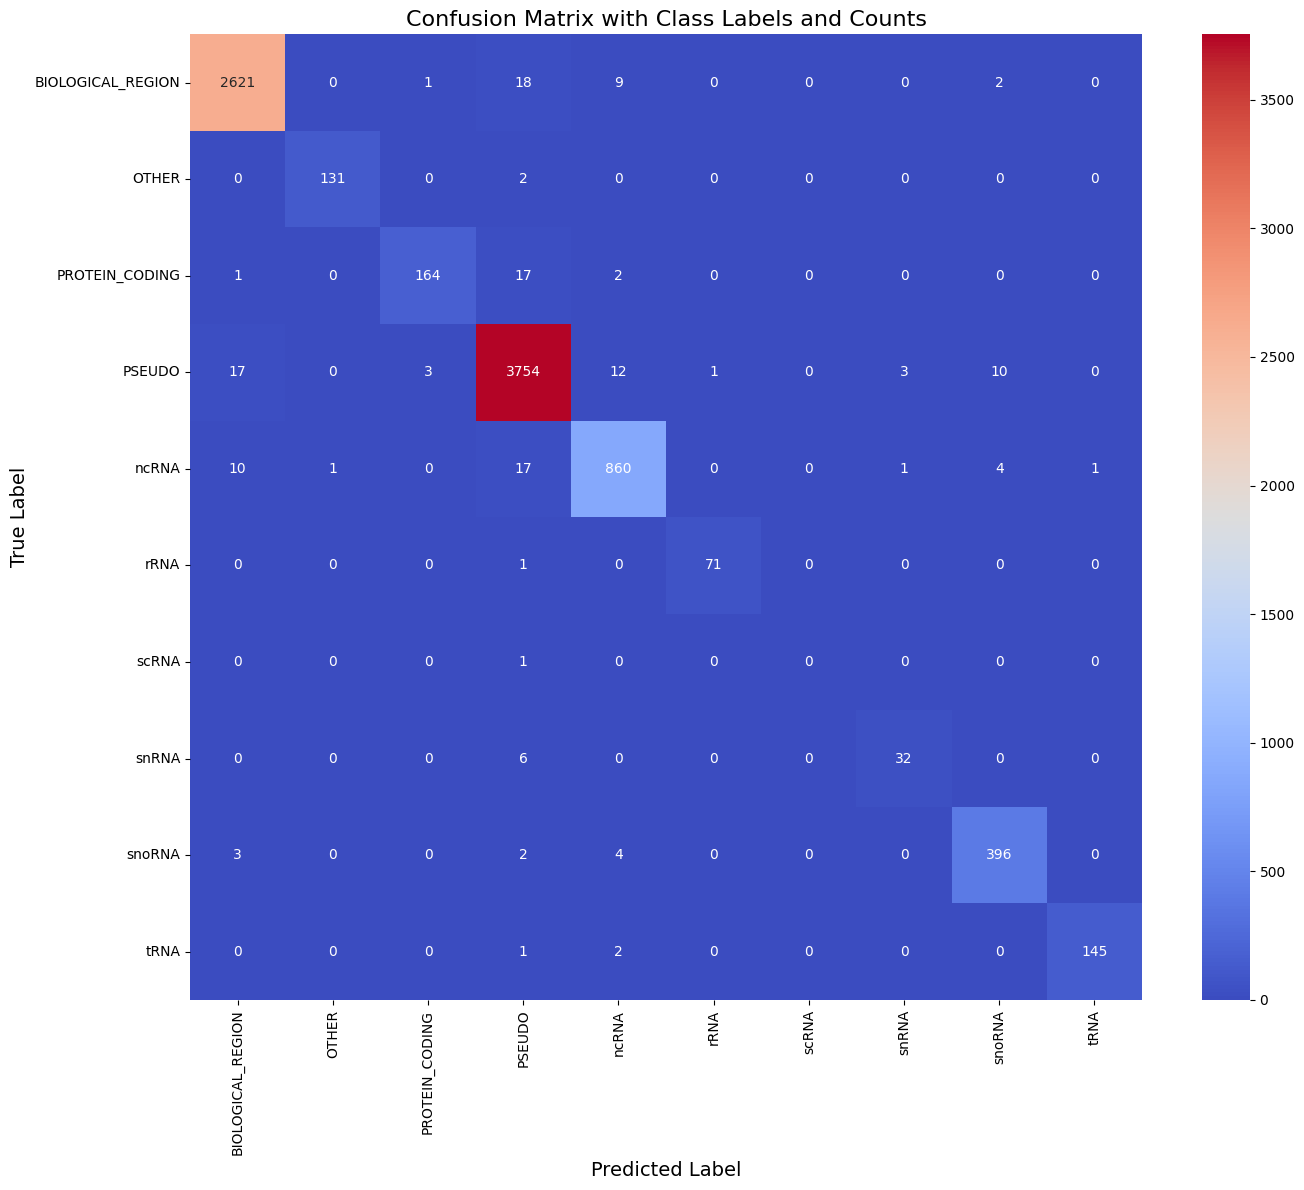

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get decoded class labels
class_names = label_encoder.inverse_transform(np.unique(y_true))

# Plot heatmap with counts and labels
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix with Class Labels and Counts', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


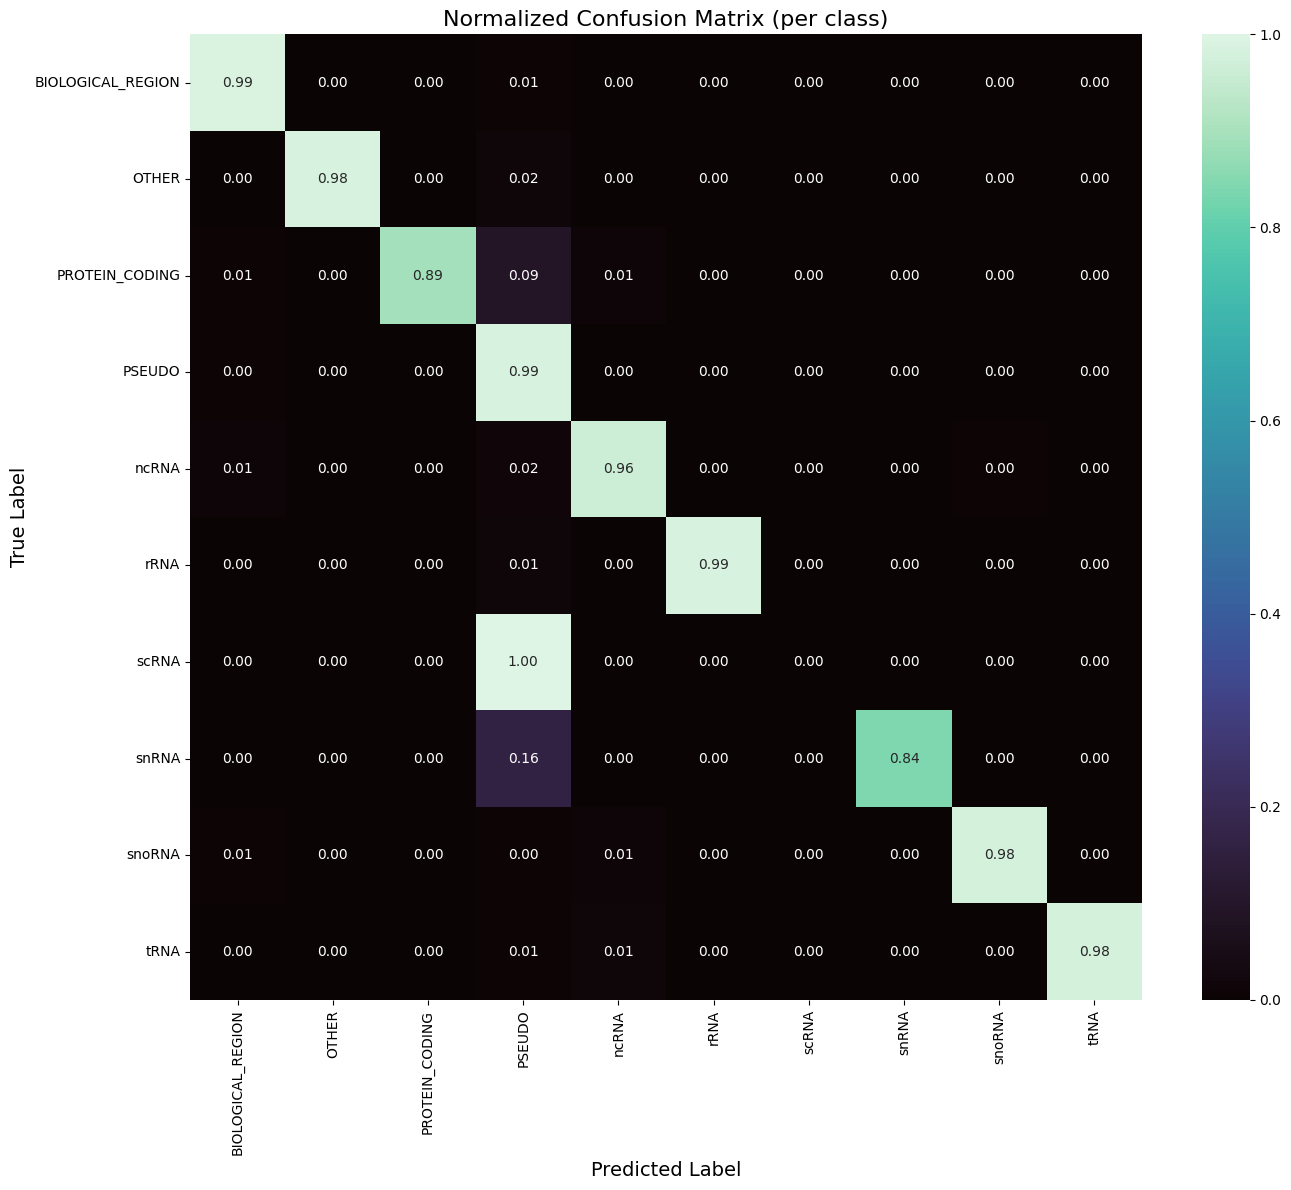

In [57]:
# Normalize by row (i.e., true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='mako',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Normalized Confusion Matrix (per class)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


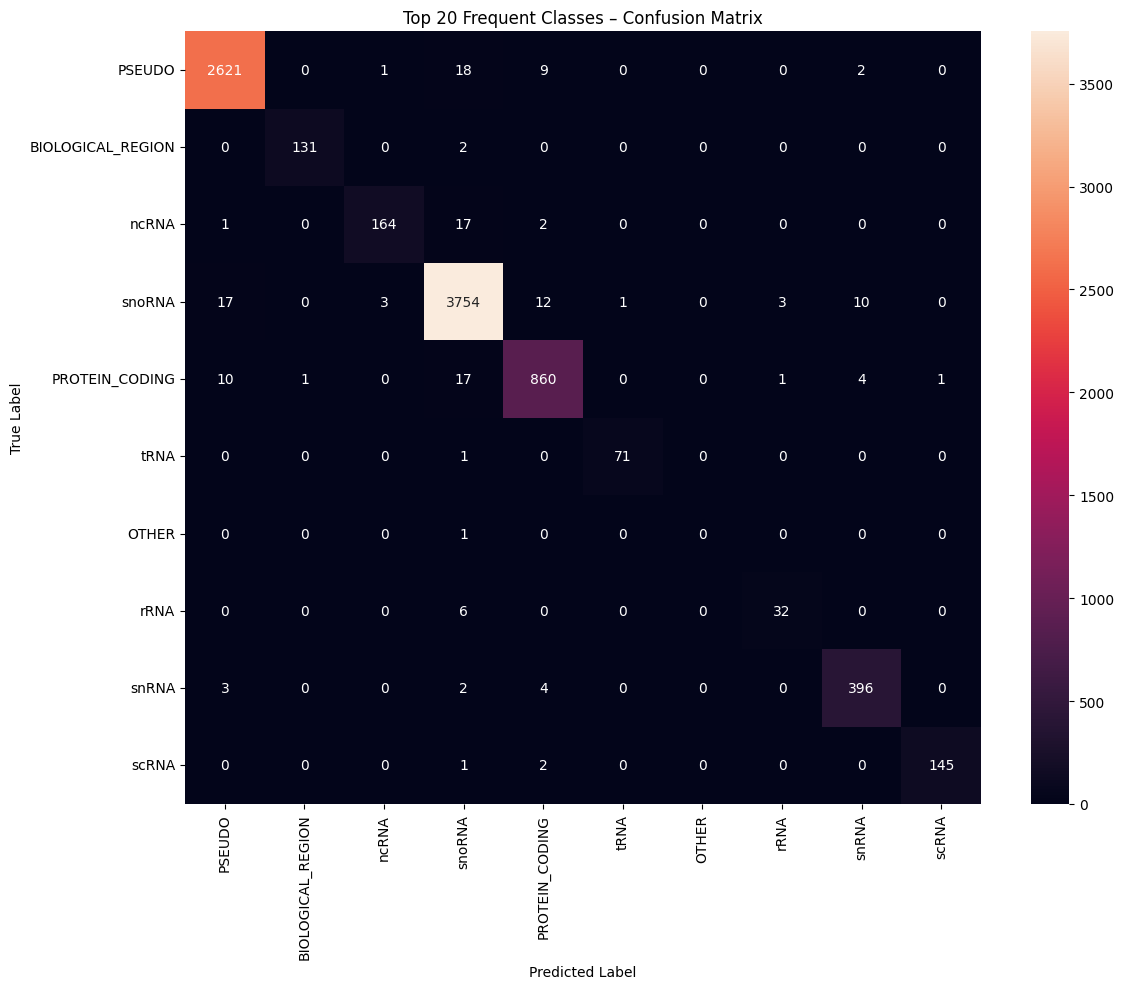

In [55]:
import pandas as pd

# Identify top 20 frequent classes in y_true
top_classes = pd.Series(y_true).value_counts().nlargest(20).index

# Filter y_true and y_pred to only include top classes
mask = np.isin(y_true, top_classes) & np.isin(y_pred, top_classes)
cm_top = confusion_matrix(np.array(y_true)[mask], np.array(y_pred)[mask])

# Decode class labels
top_class_labels = label_encoder.inverse_transform(top_classes)

# Plot top 20 confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_top, annot=True, fmt='d', cmap='rocket',
            xticklabels=top_class_labels, yticklabels=top_class_labels)
plt.title('Top 20 Frequent Classes – Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


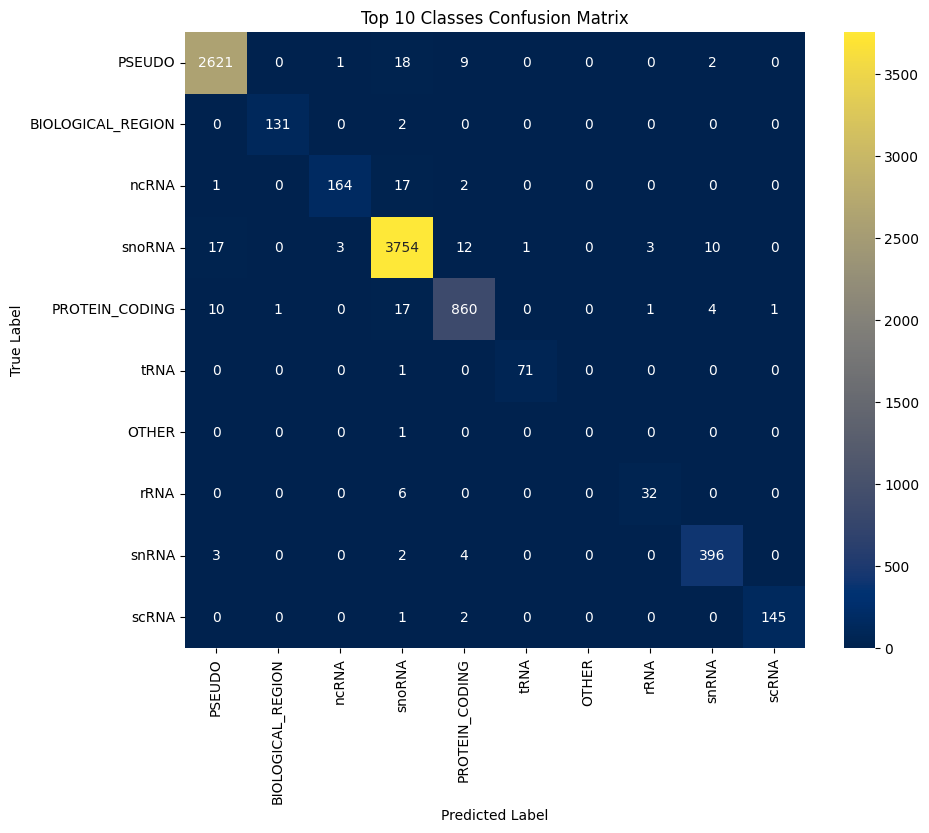

In [54]:
# Optionally show a reduced confusion matrix (top 10 classes by frequency)
import pandas as pd

class_counts = pd.Series(y_true).value_counts().nlargest(10).index
mask = np.isin(y_true, class_counts) & np.isin(y_pred, class_counts)

cm_top = confusion_matrix(np.array(y_true)[mask], np.array(y_pred)[mask])
labels = label_encoder.inverse_transform(class_counts)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_top, annot=True, xticklabels=labels, yticklabels=labels, fmt='d', cmap='cividis')
plt.title('Top 10 Classes Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


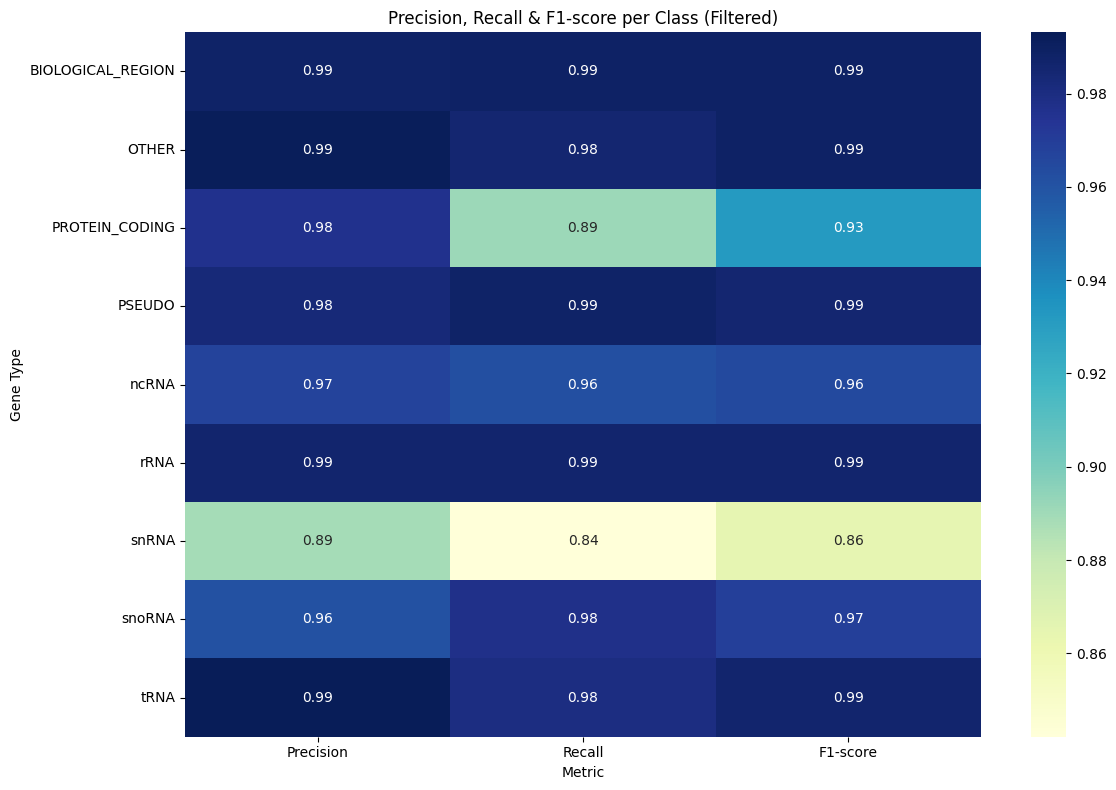

In [22]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get scores
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
class_names = label_encoder.inverse_transform(np.unique(y_true))

# Create dataframe
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}, index=class_names)

# 🔍 Remove any row where all values are zero (e.g., scRNA)
metrics_df = metrics_df[(metrics_df != 0).any(axis=1)]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Precision, Recall & F1-score per Class (Filtered)')
plt.ylabel('Gene Type')
plt.xlabel('Metric')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


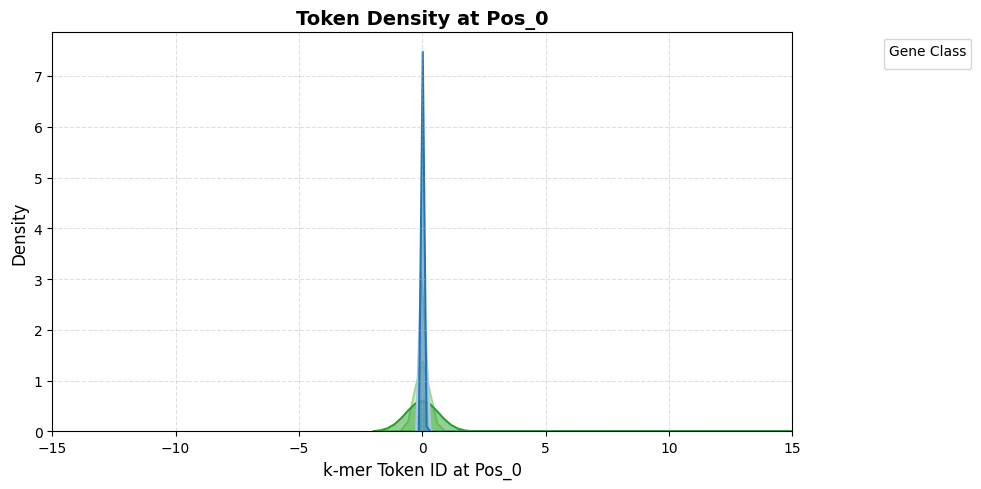

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


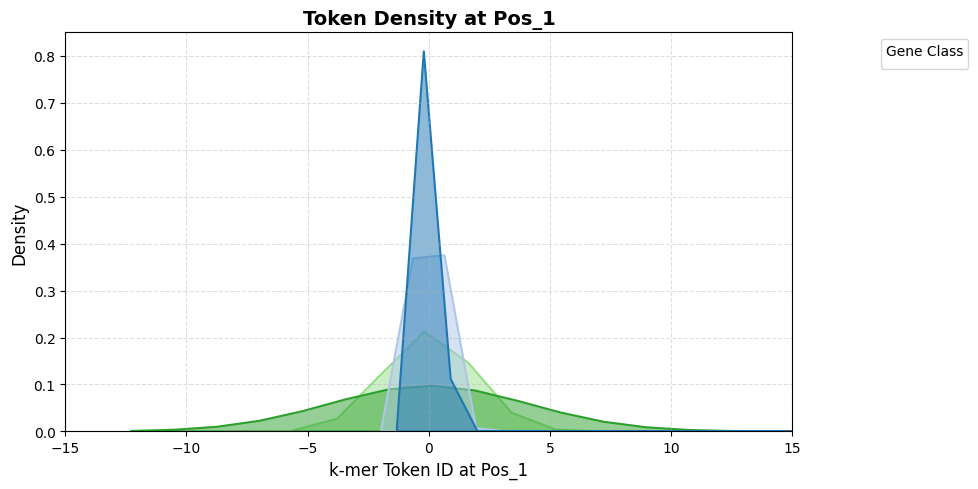

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


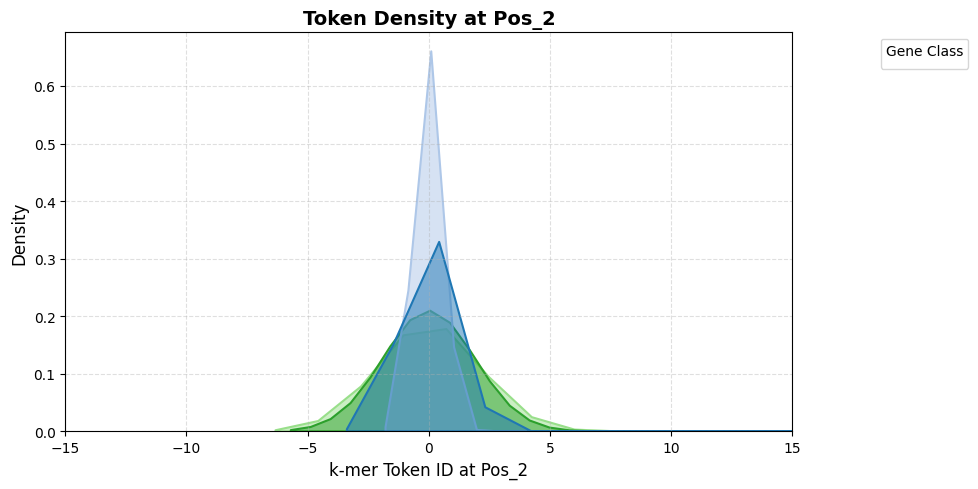

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


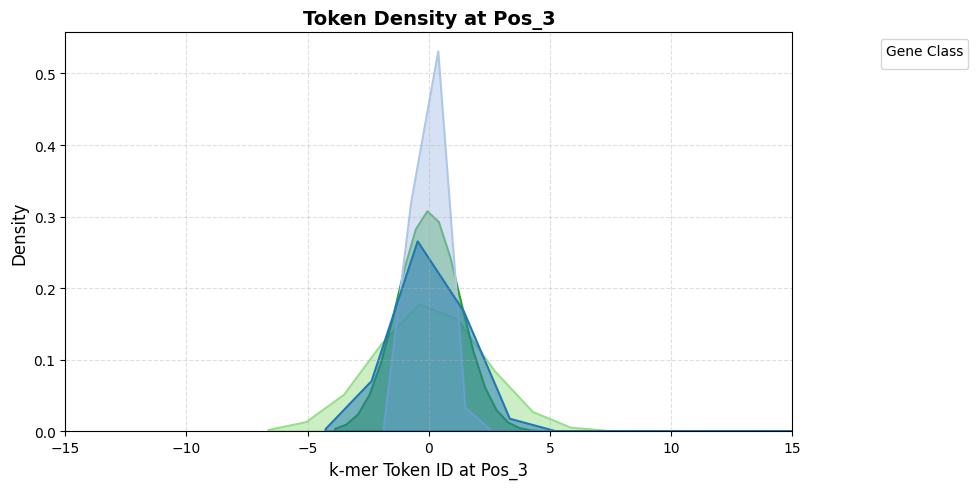

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


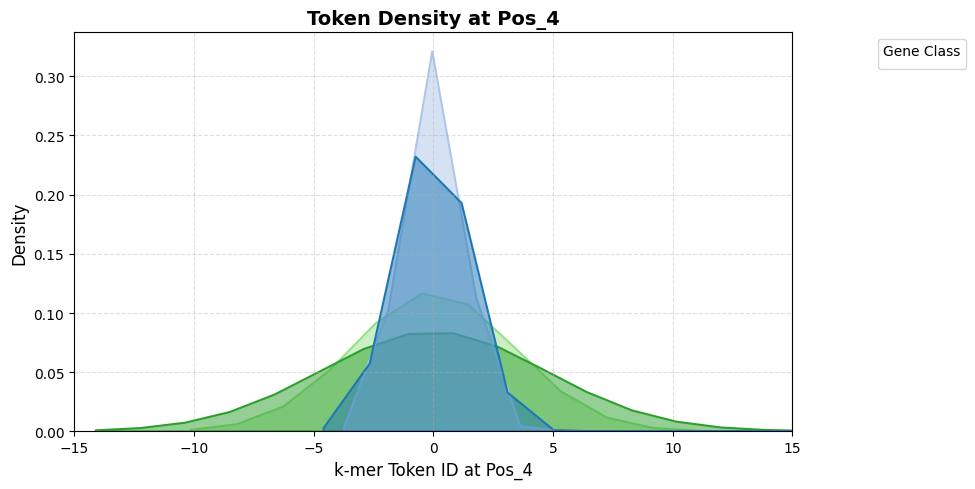

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


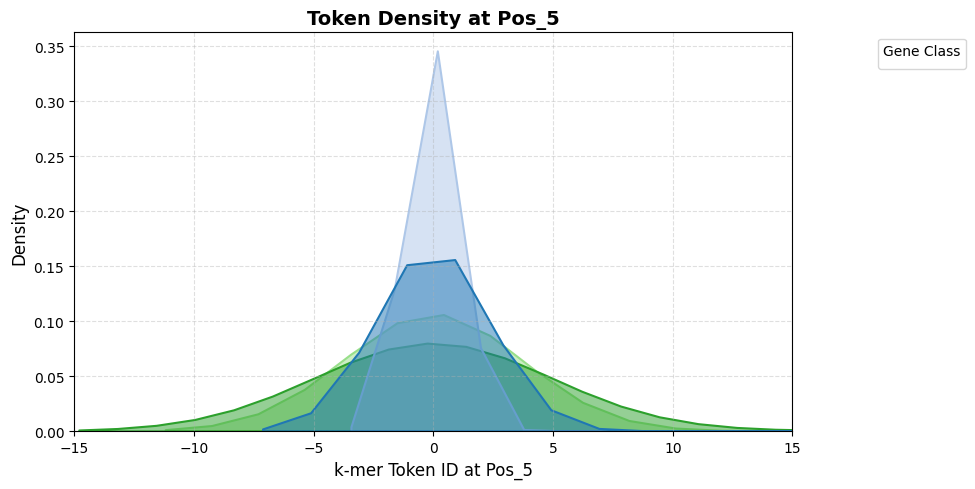

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


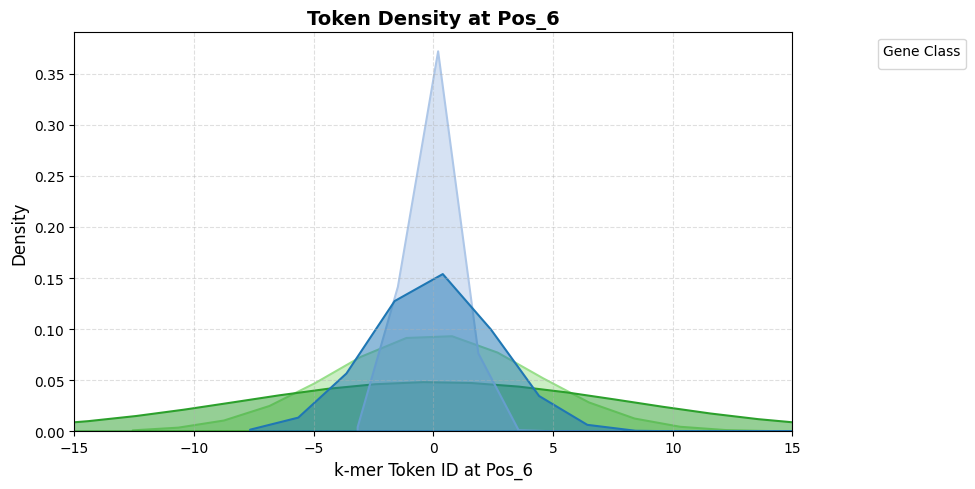

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


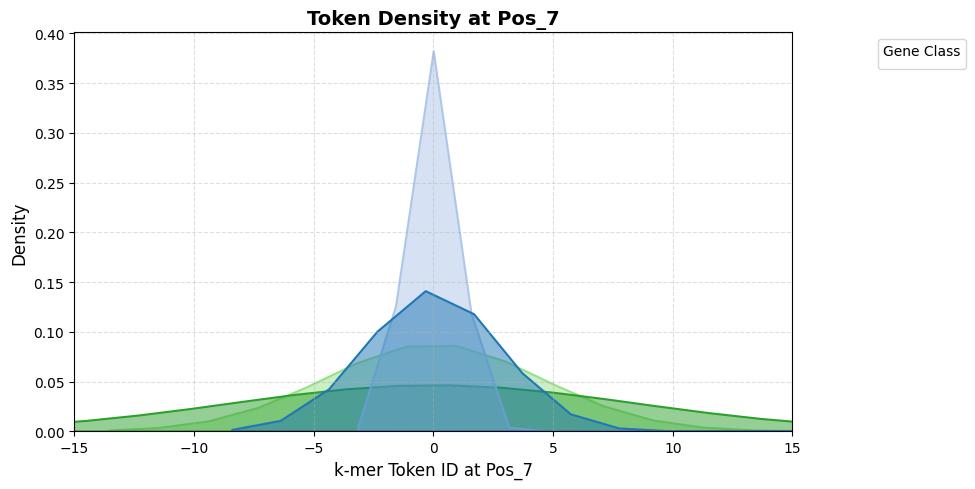

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


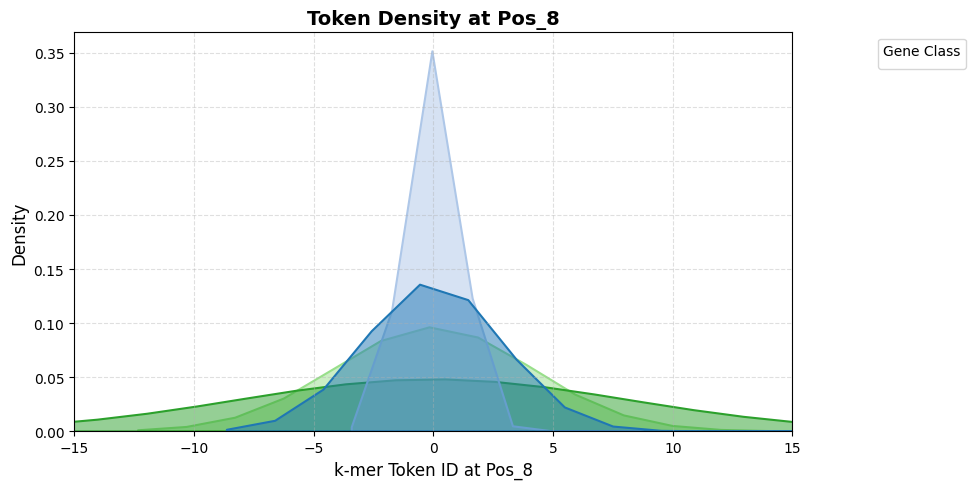

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


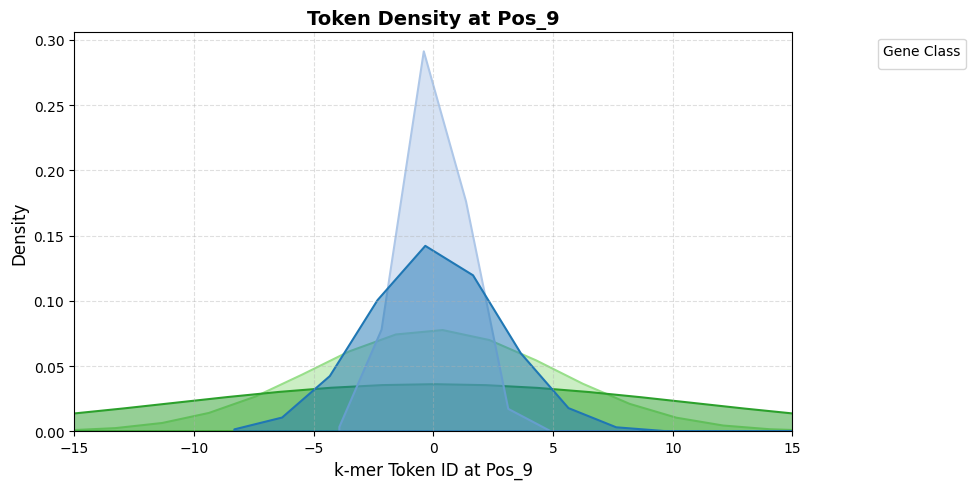

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


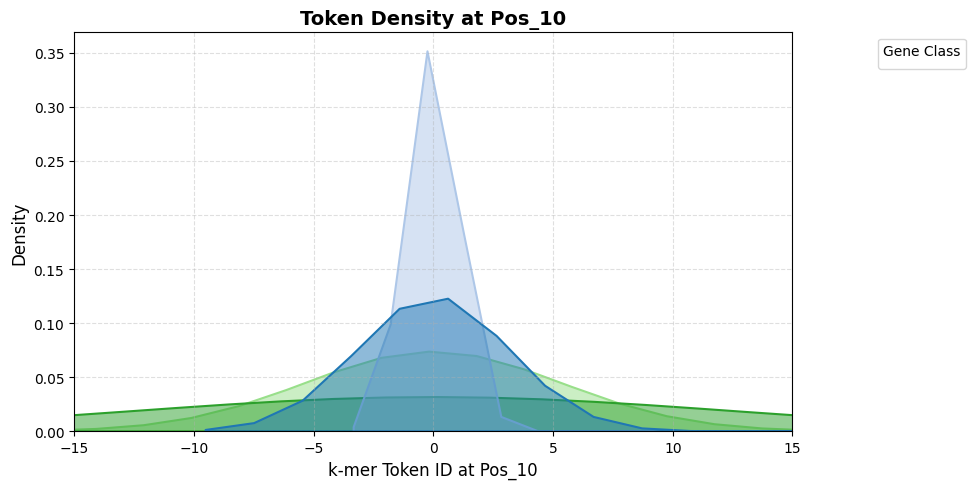

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


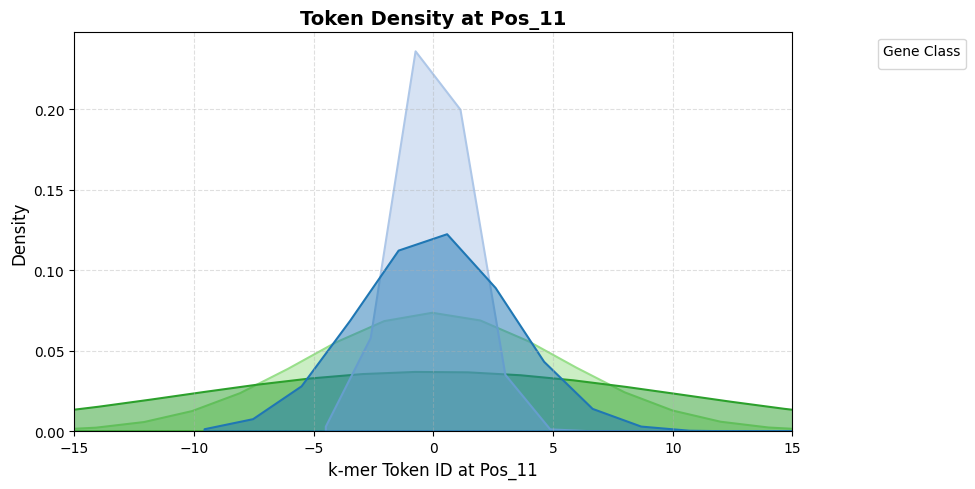

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


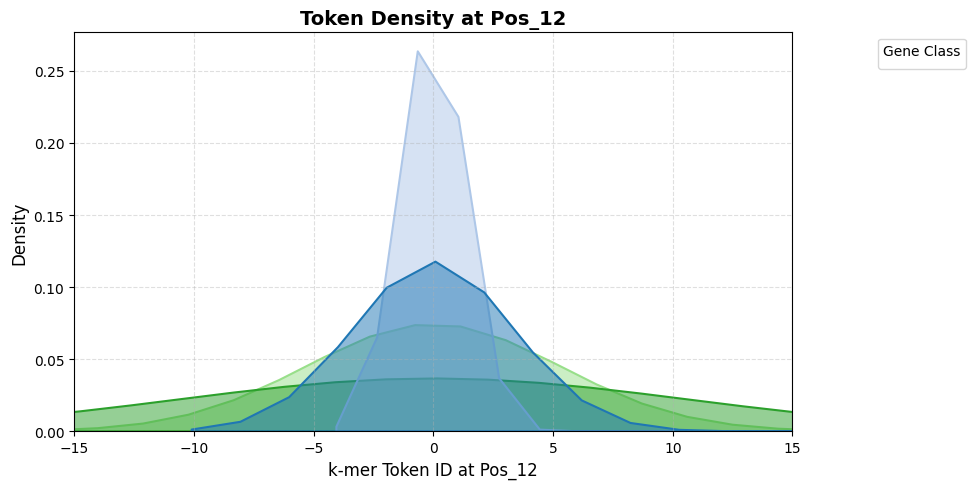

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


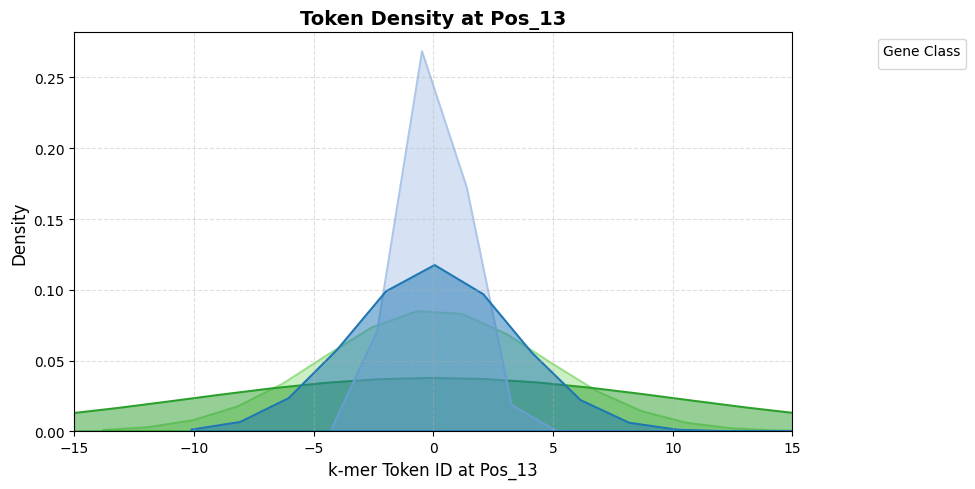

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


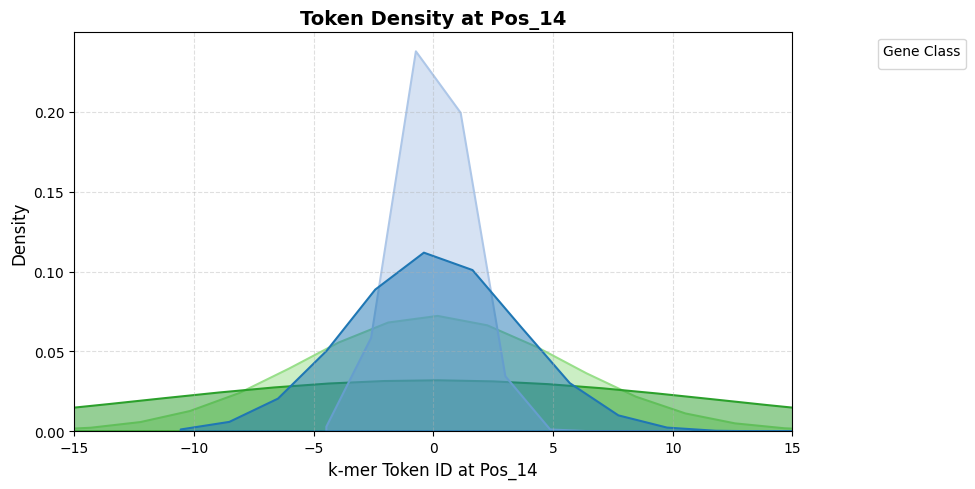

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


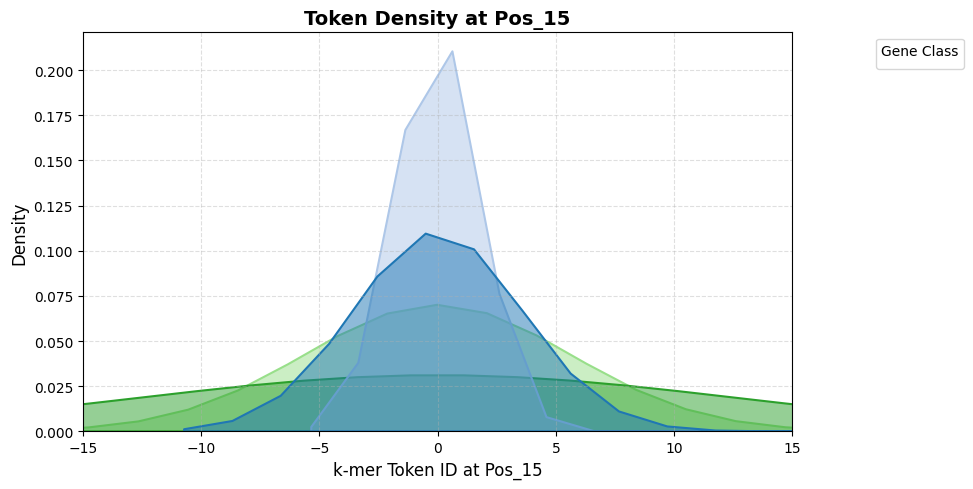

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


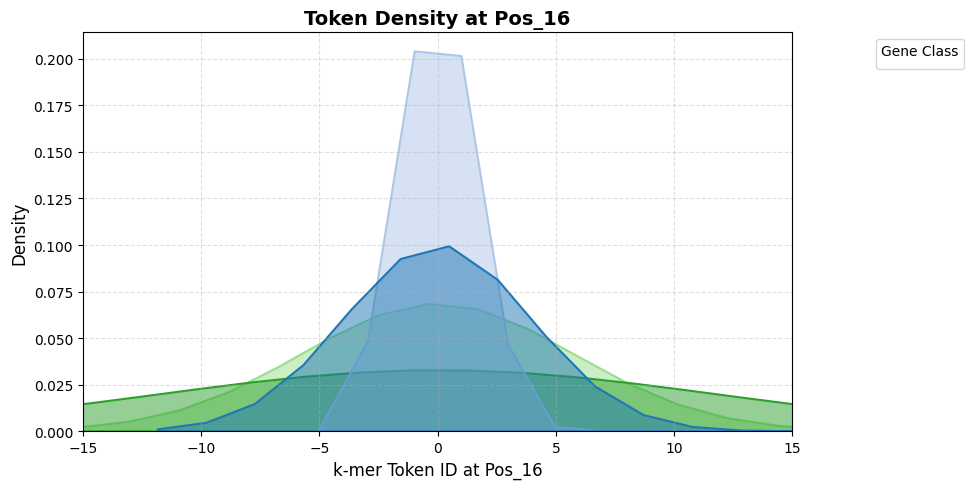

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


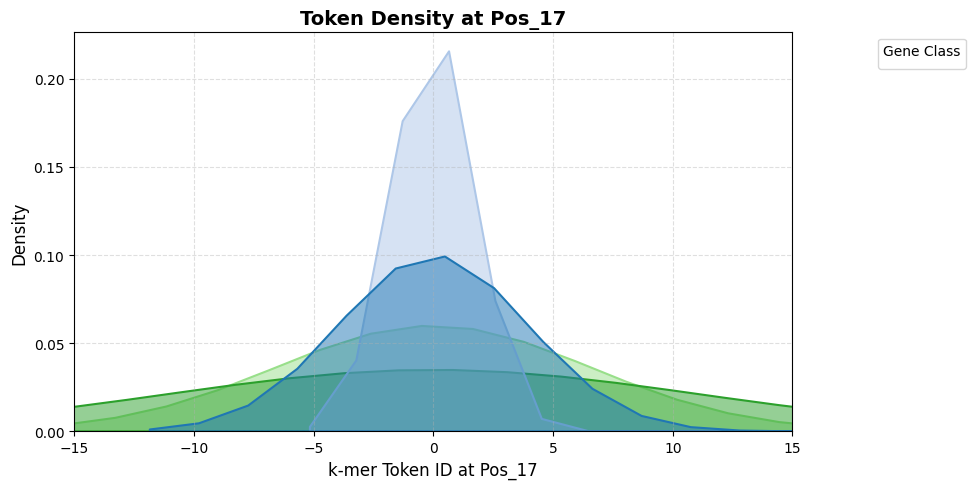

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


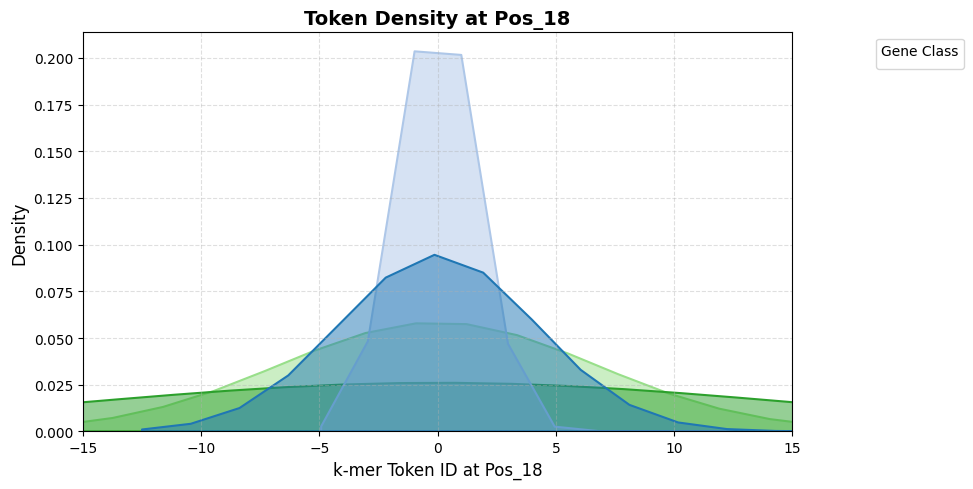

C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\r\AppData\Local\Temp\ipykernel_28132\1519231486.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))


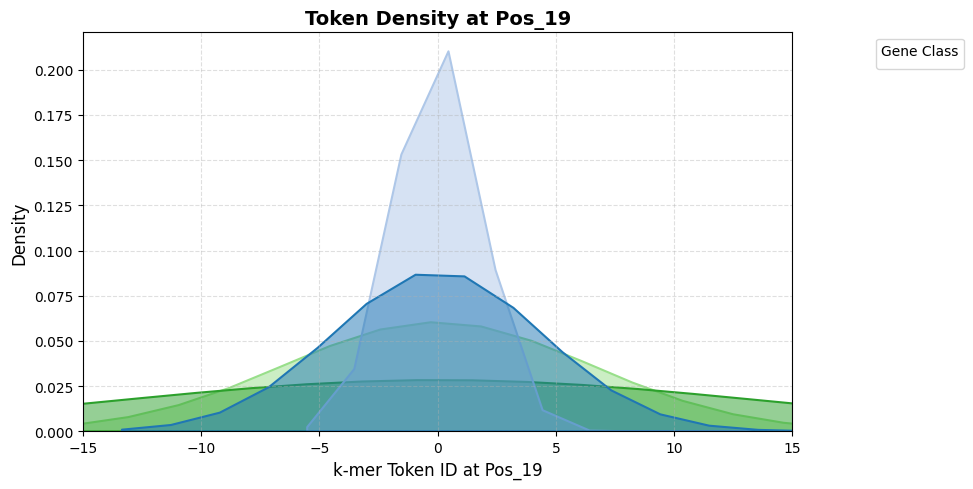

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Create output folder
os.makedirs("results/feature_distributions_kde", exist_ok=True)

# Limit to first N positions
N = 20
df_features = pd.DataFrame(X_train_pad[:, :N])
df_features.columns = [f"Pos_{i}" for i in range(N)]  # Rename columns for clarity
df_features['GeneType'] = label_encoder.inverse_transform(y_train_enc)

# Optionally remove rare class
df_features = df_features[df_features['GeneType'] != 'scRNA']

# Plot KDE for each position
for col in df_features.columns[:-1]:  # Exclude 'GeneType'
    plt.figure(figsize=(10, 5))
    sns.kdeplot(
        data=df_features,
        x=col,
        hue='GeneType',
        common_norm=False,
        palette='tab20',
        fill=True,
        alpha=0.5,
        linewidth=1.5
    )
    plt.title(f'Token Density at {col}', fontsize=14, fontweight='bold')
    plt.xlabel(f'k-mer Token ID at {col}', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xlim(-15, 15)  # Zoom x-axis to token IDs between 0 and 10
    plt.legend(title='Gene Class', fontsize=9, loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(f'results/feature_distributions_kde/kde_dist_{col}.png')
    plt.show()


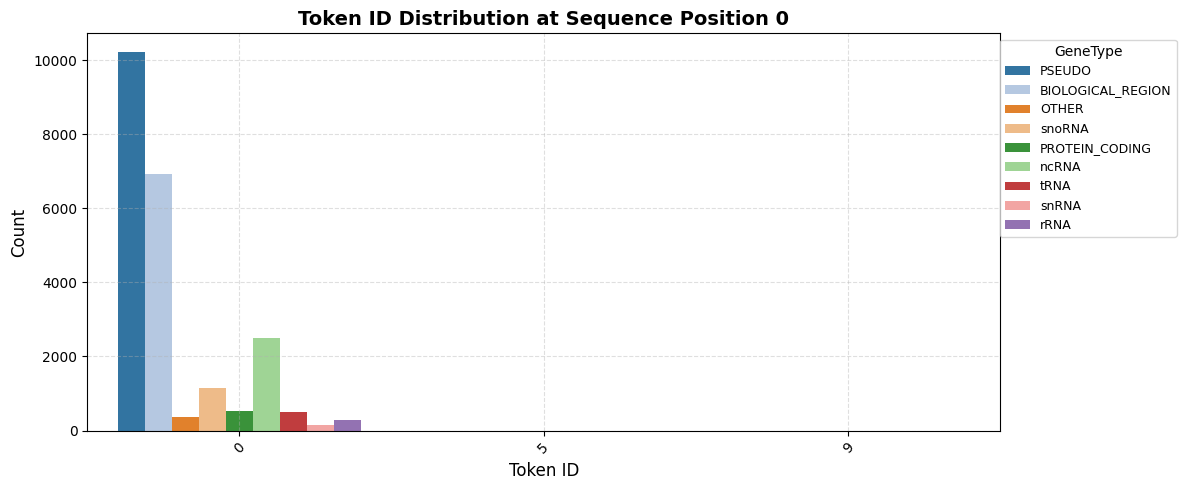

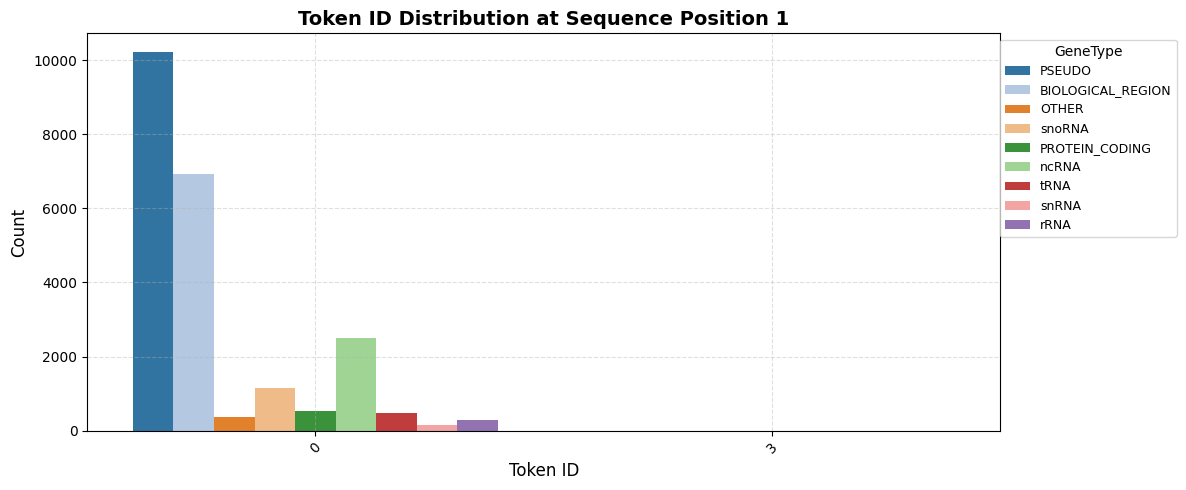

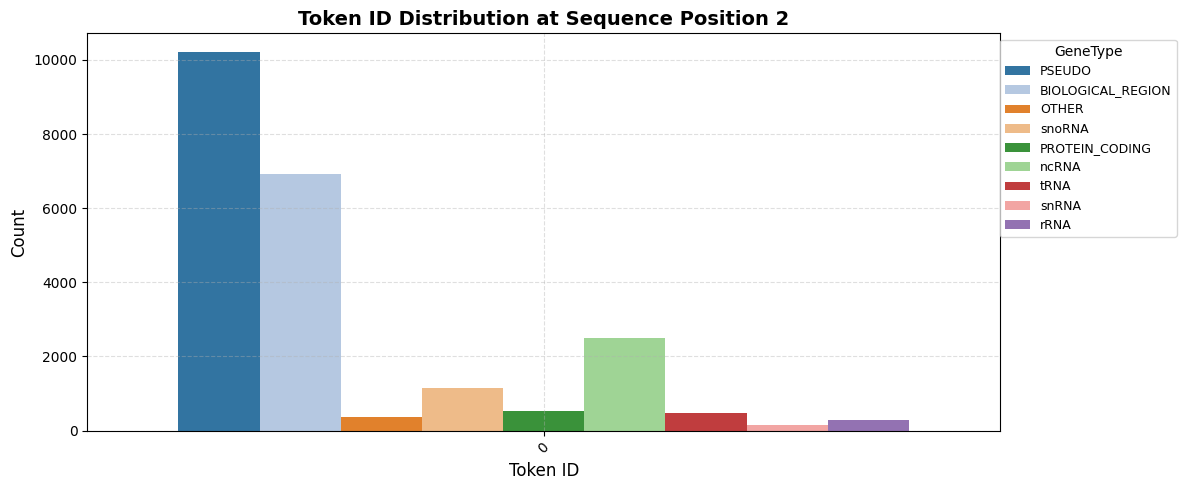

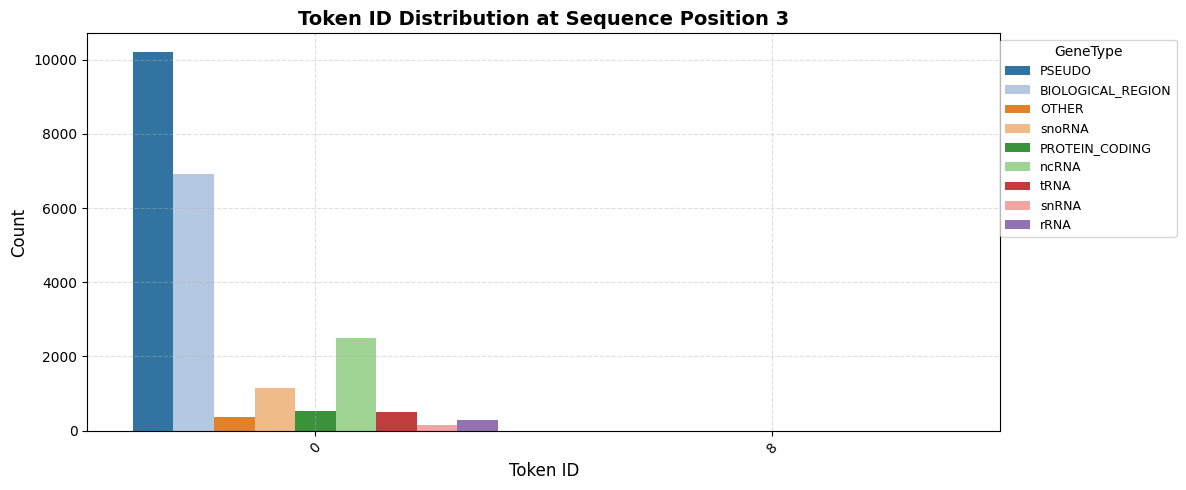

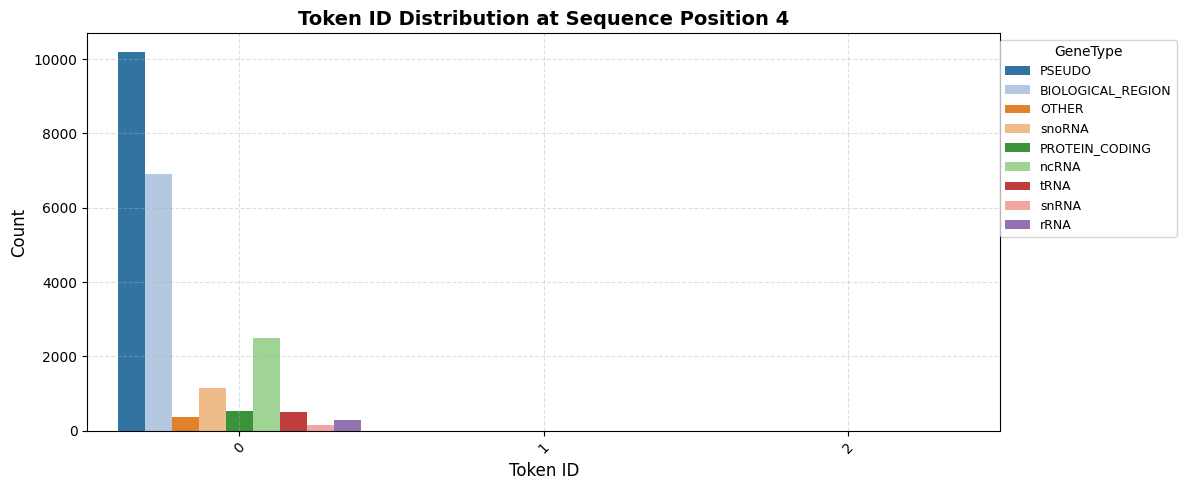

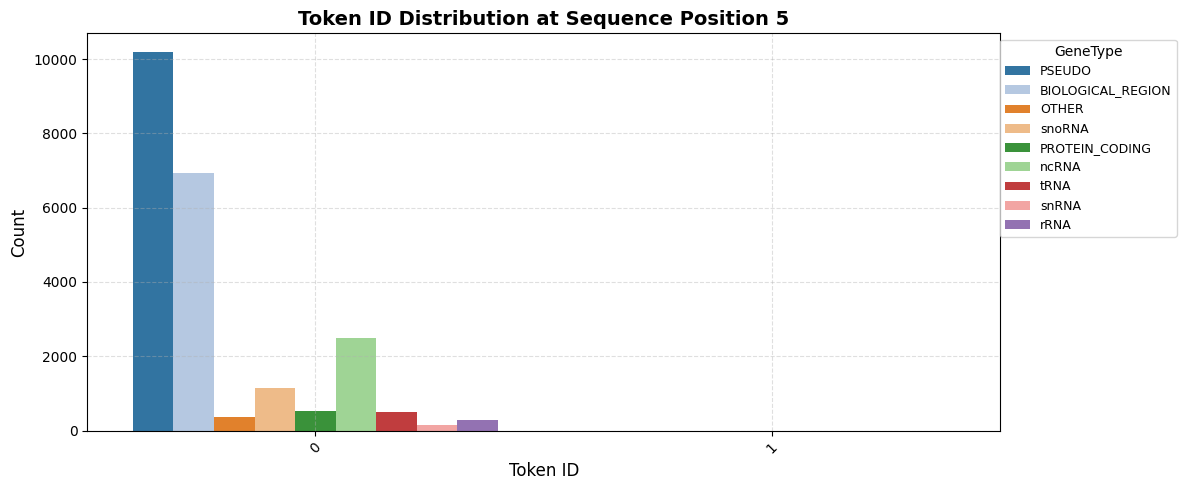

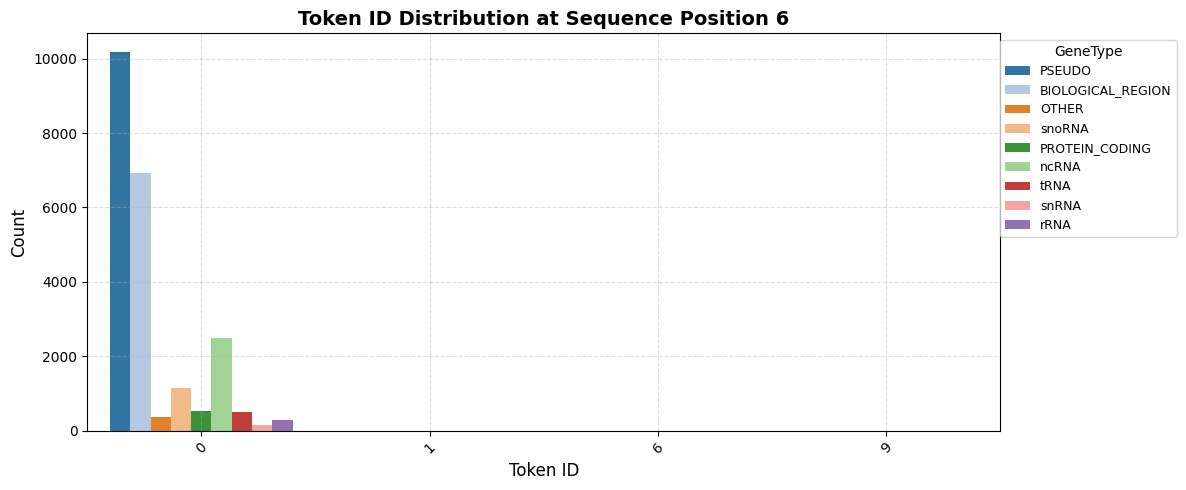

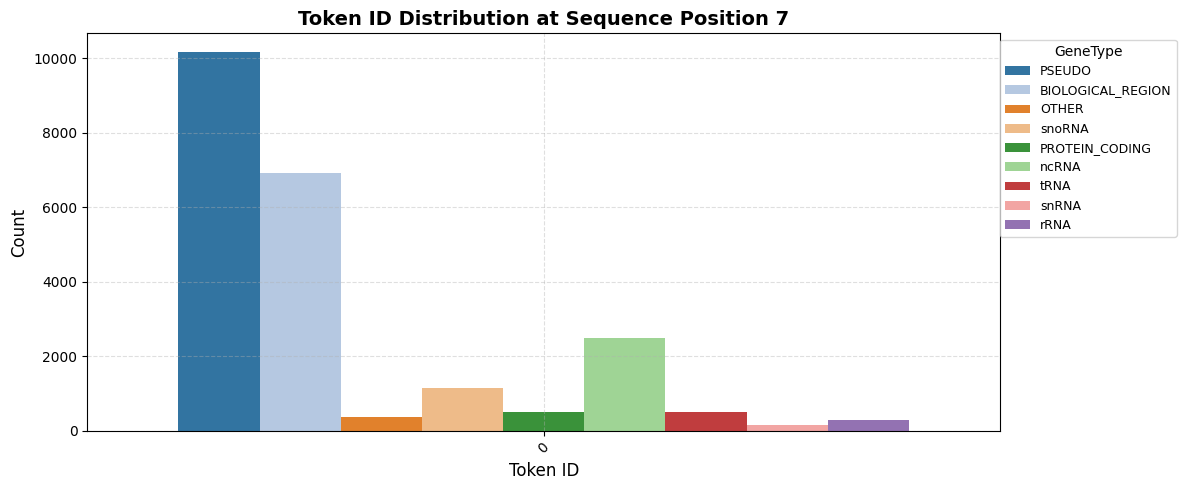

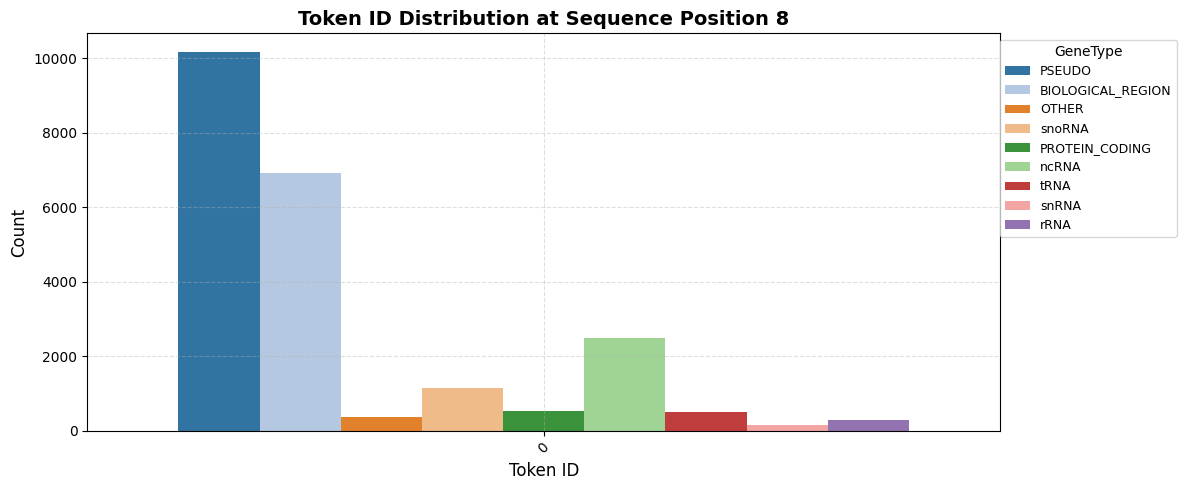

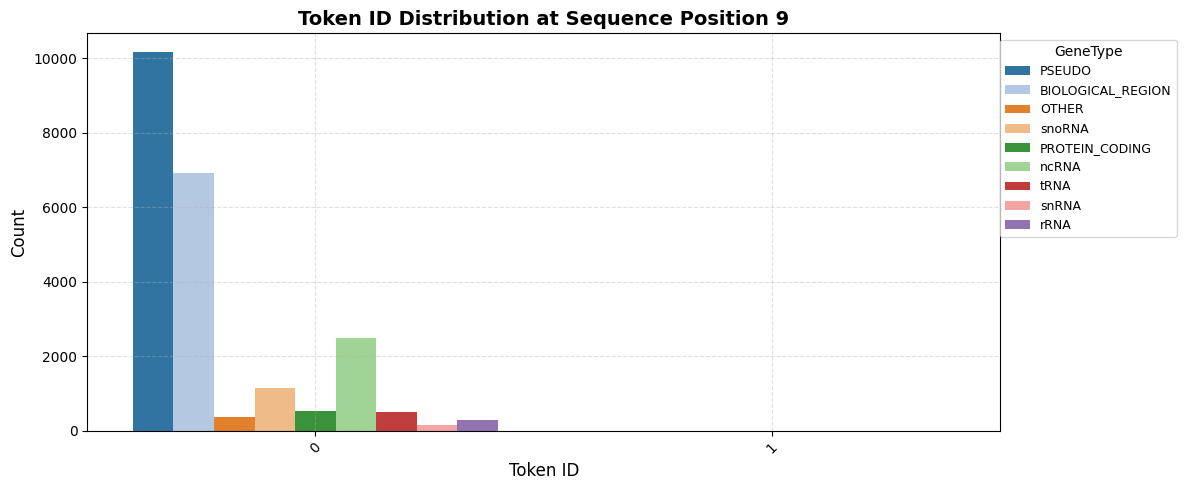

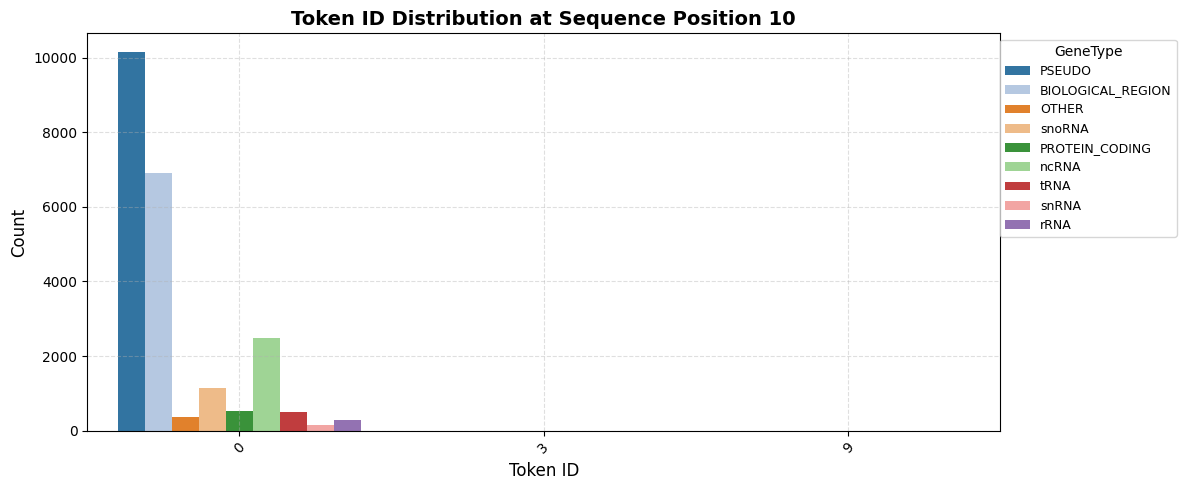

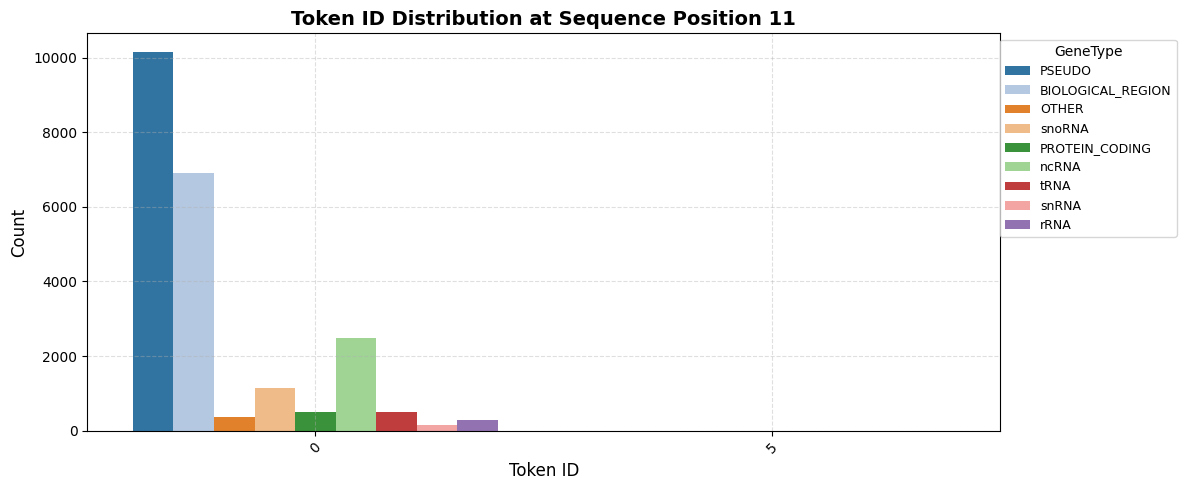

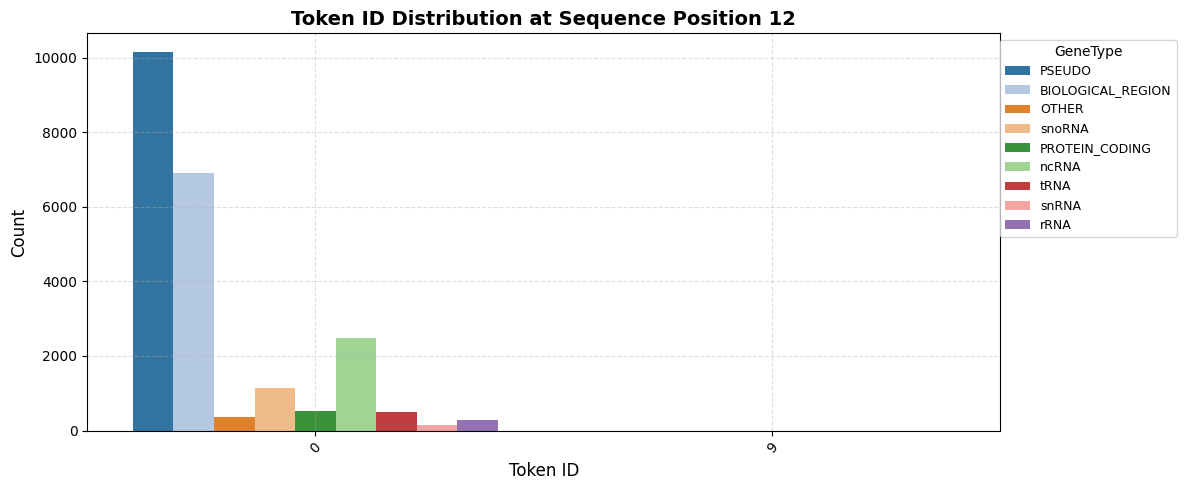

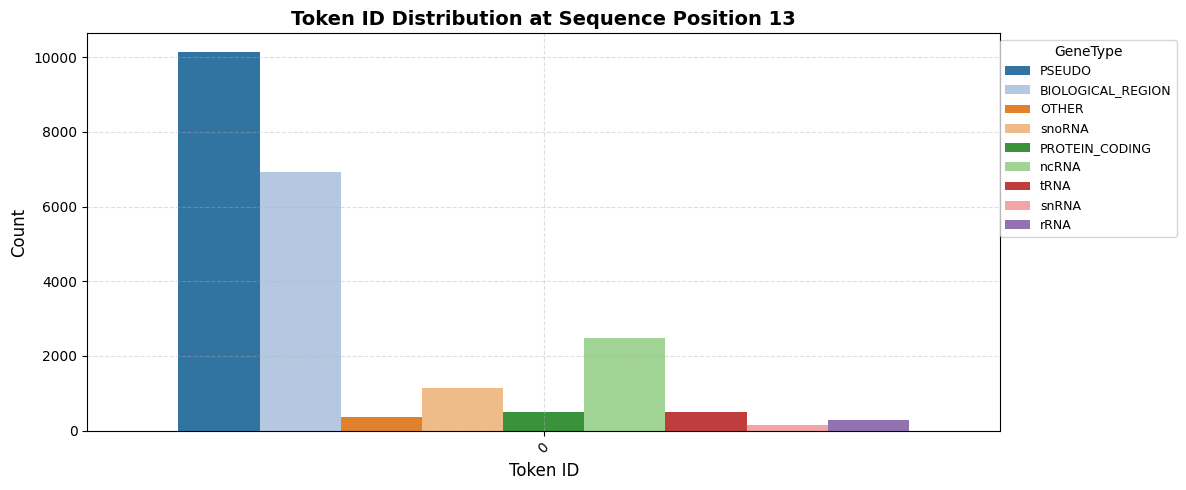

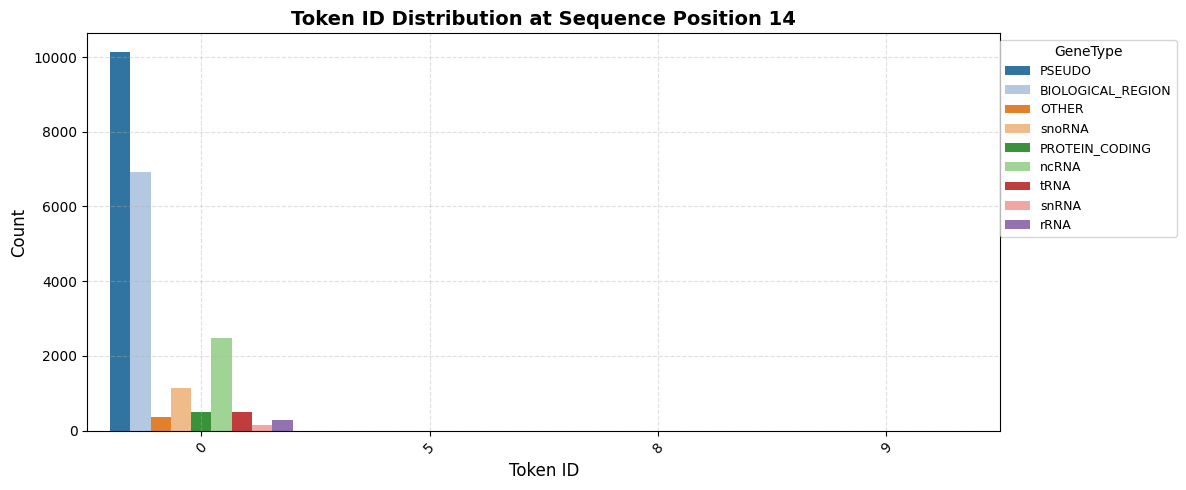

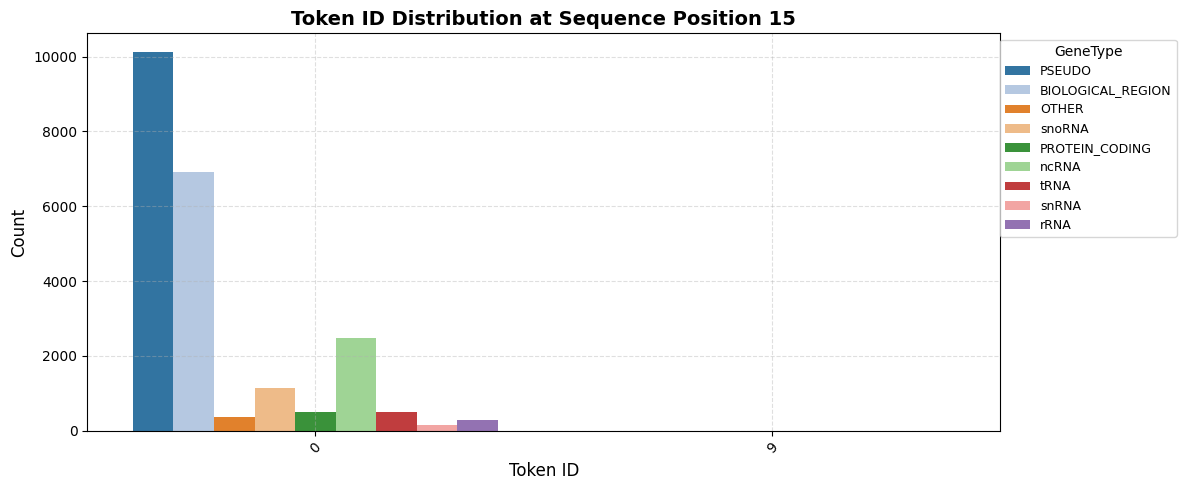

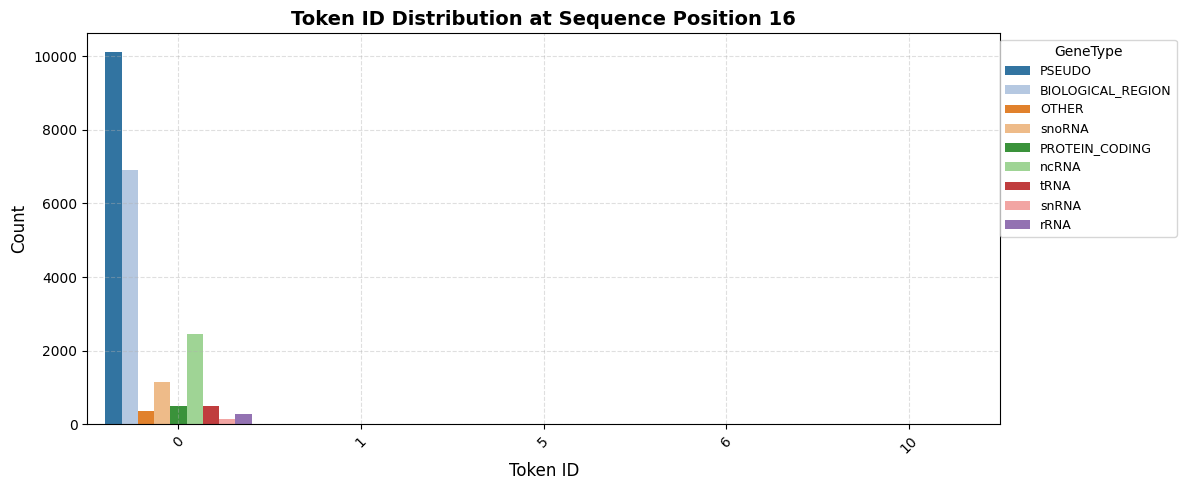

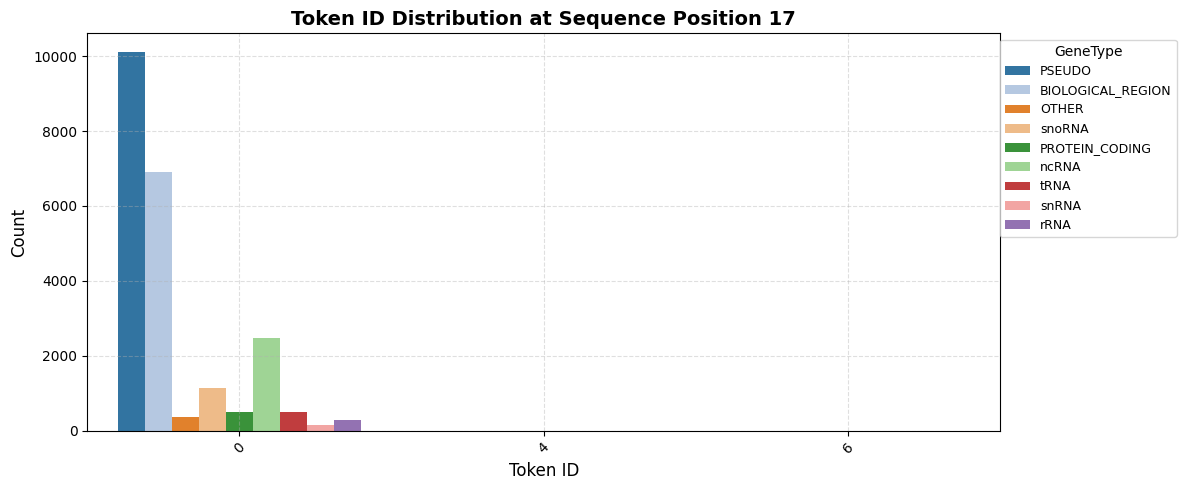

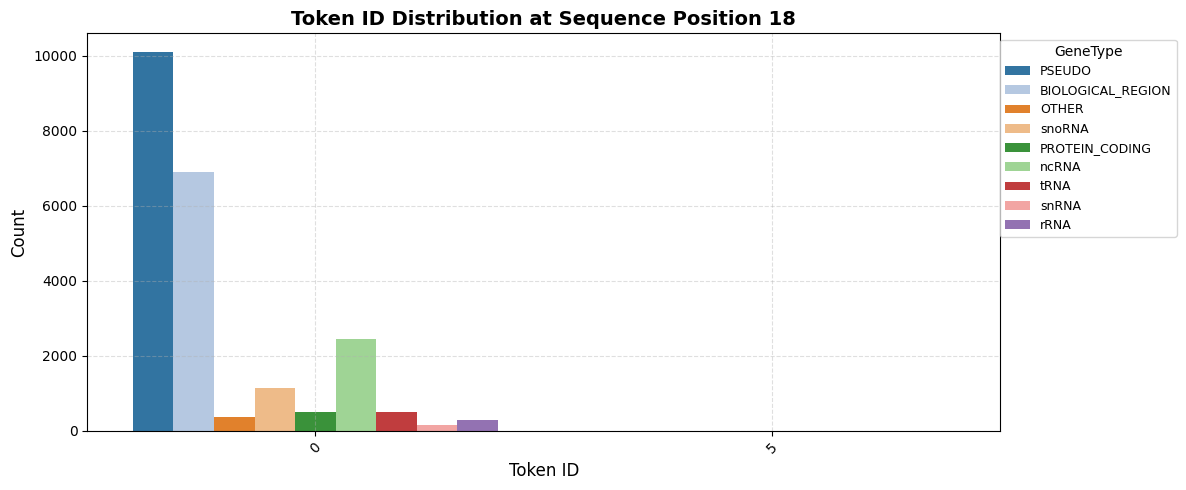

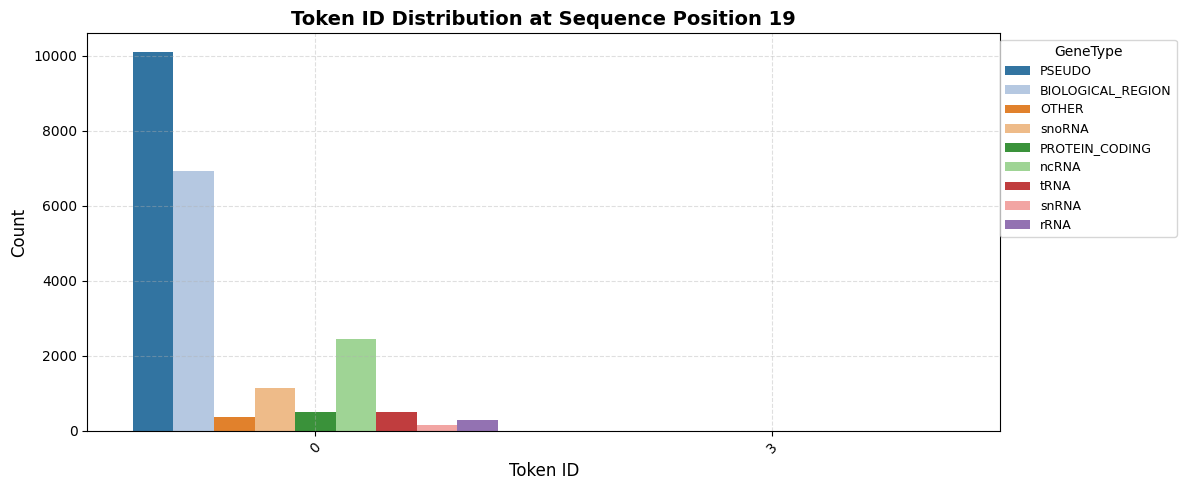

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

# Create output directory
os.makedirs("results/feature_distributions_countplot", exist_ok=True)

# Convert features to DataFrame
N = 20  # Number of positions to visualize
df_feat = pd.DataFrame(X_train_pad[:, :N])
df_feat['GeneType'] = label_encoder.inverse_transform(y_train_enc)

# Drop rare class (optional)
df_feat = df_feat[df_feat['GeneType'] != 'scRNA']

# Melt to long format for seaborn
df_long = df_feat.melt(id_vars='GeneType', var_name='Position', value_name='TokenID')

# Limit TokenID to 0–10 for x-axis filtering
df_long = df_long[df_long['TokenID'].between(0, 10)]

# Plot token distributions for each position
for pos in range(N):
    plt.figure(figsize=(12, 5))
    df_pos = df_long[df_long['Position'] == pos]
    
    sns.countplot(data=df_pos, x='TokenID', hue='GeneType', palette='tab20')
    plt.title(f'Token ID Distribution at Sequence Position {pos}', fontsize=14, fontweight='bold')
    plt.xlabel('Token ID', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='GeneType', fontsize=9, loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(f"results/feature_distributions_countplot/token_dist_pos_{pos}_token0to10.png")
    plt.show()


C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


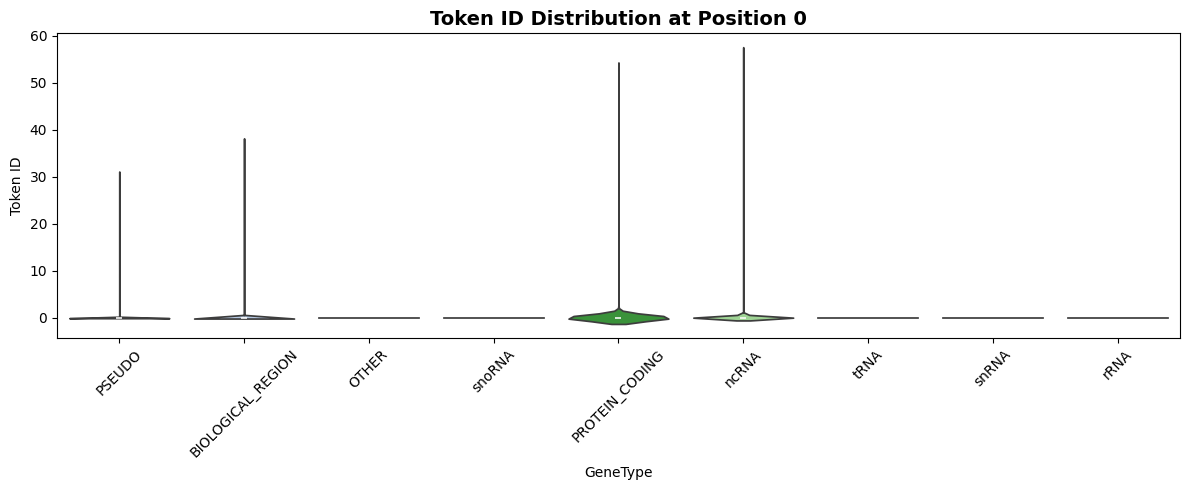

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


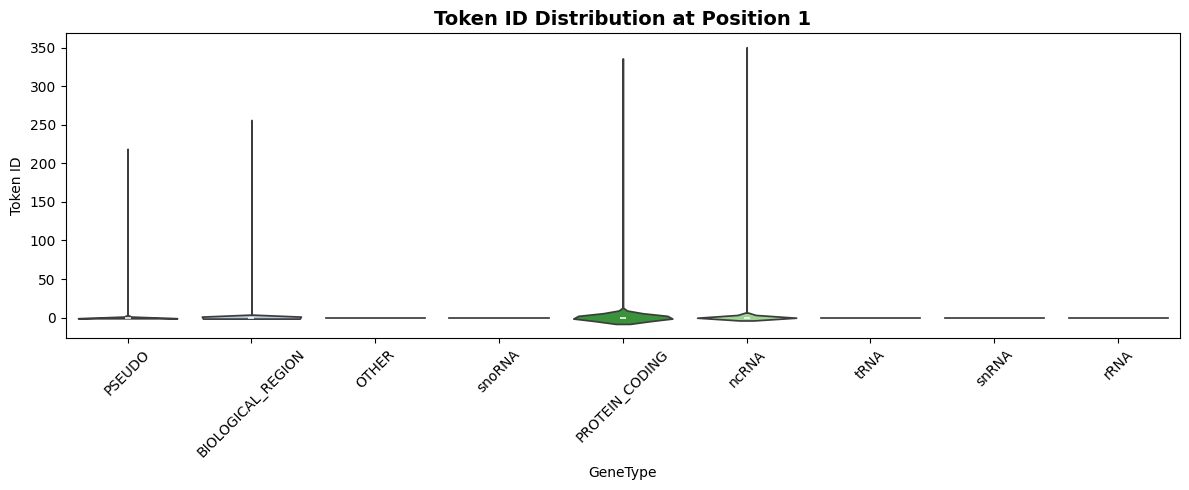

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


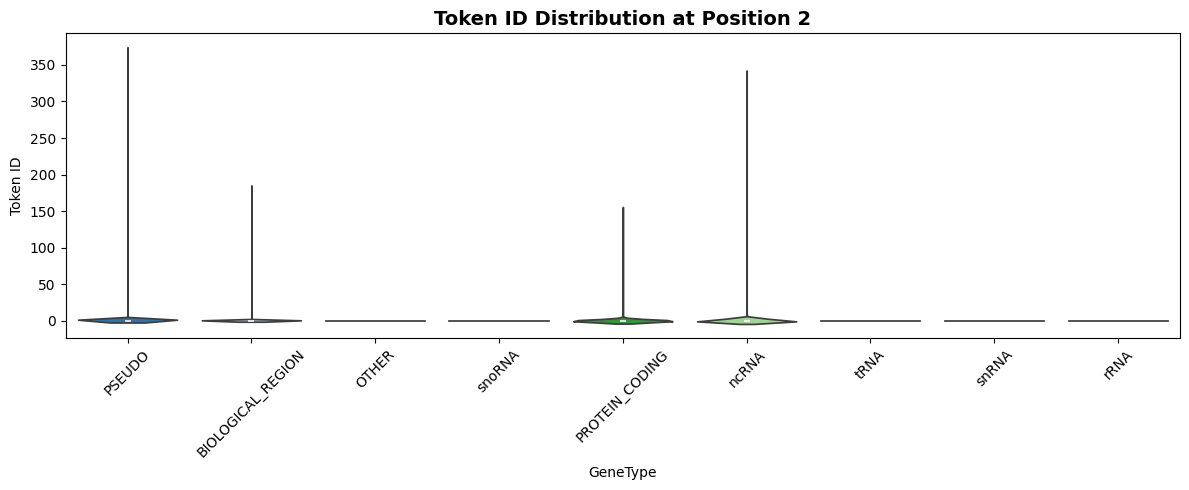

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


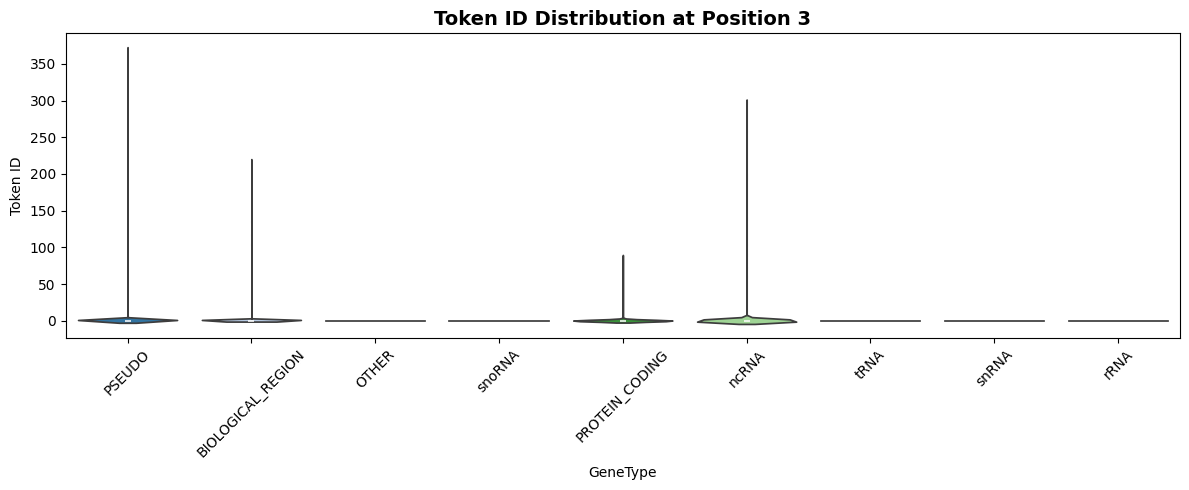

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


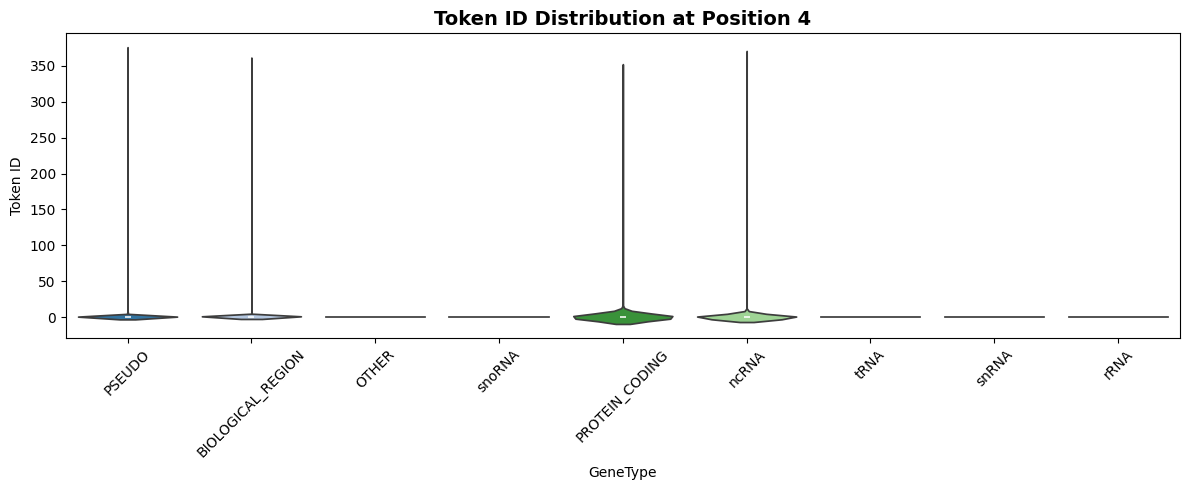

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


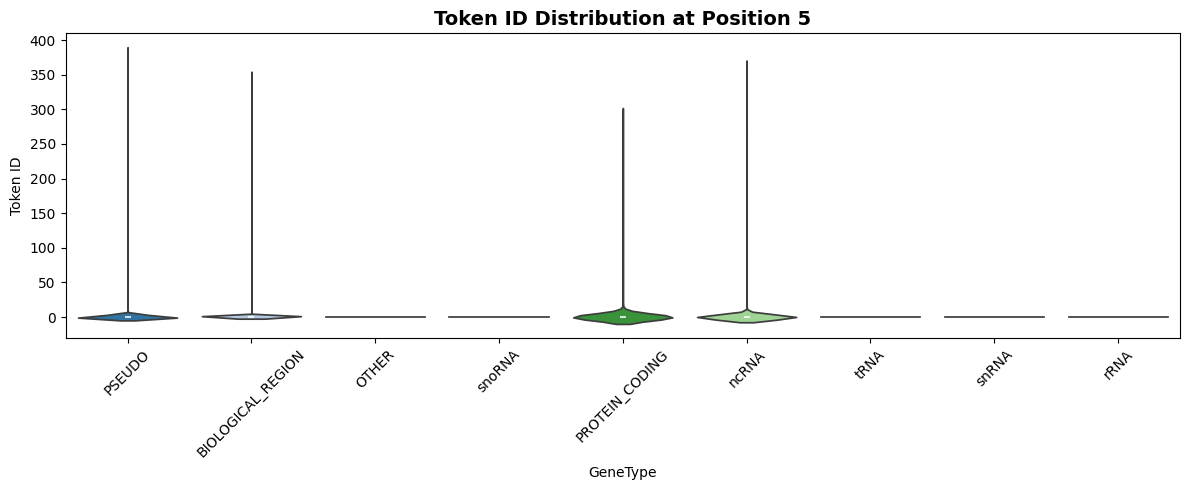

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


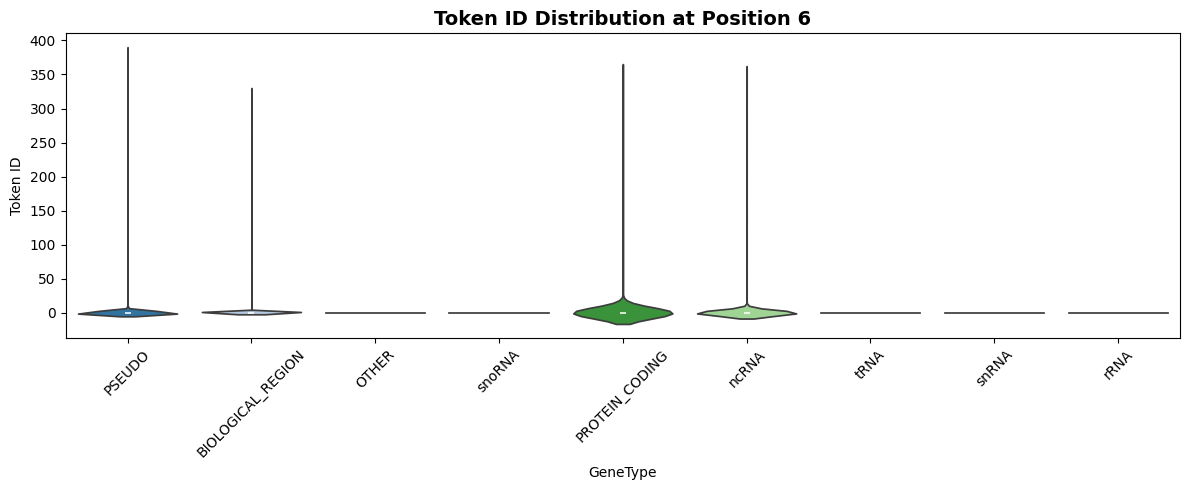

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


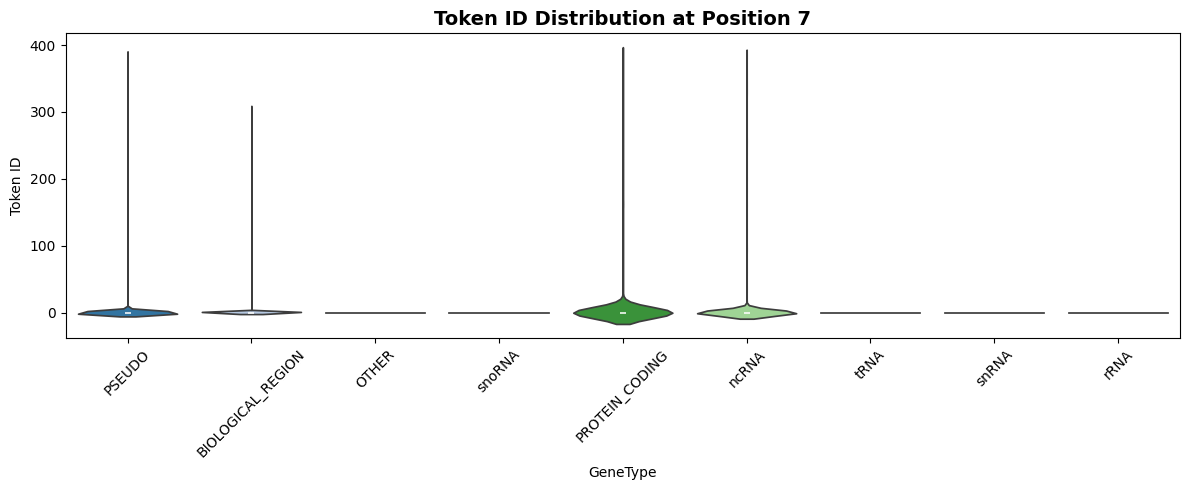

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


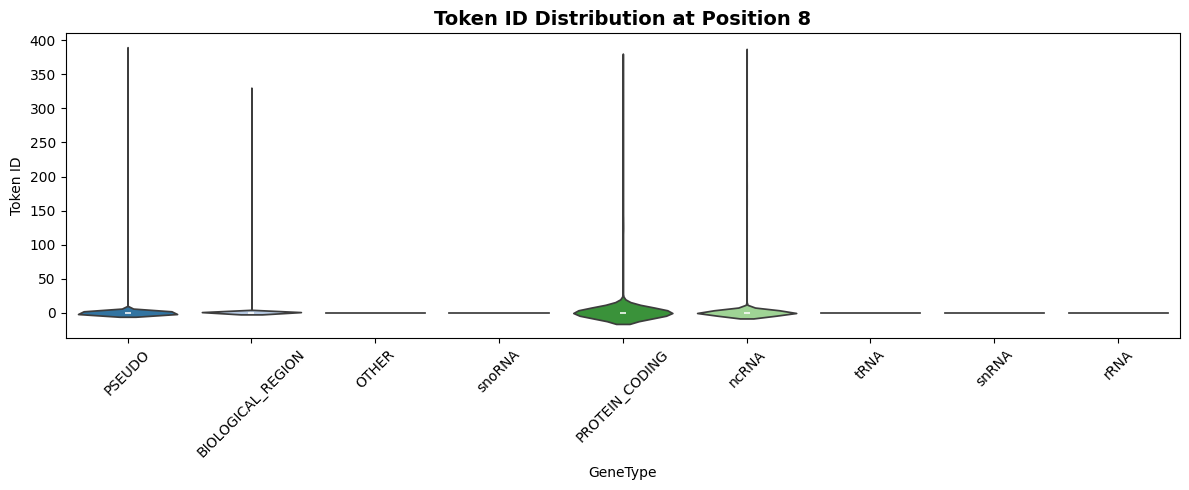

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


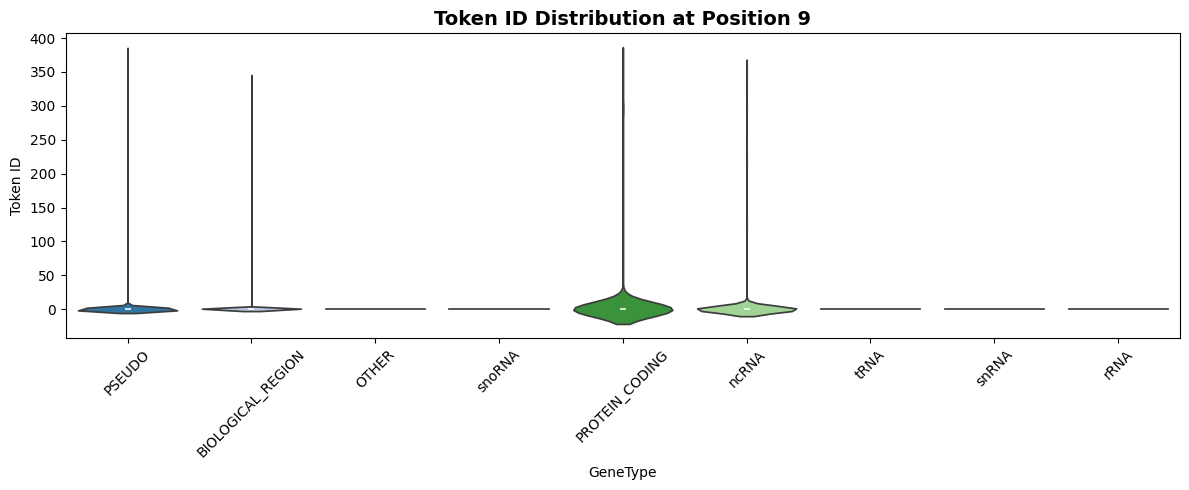

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


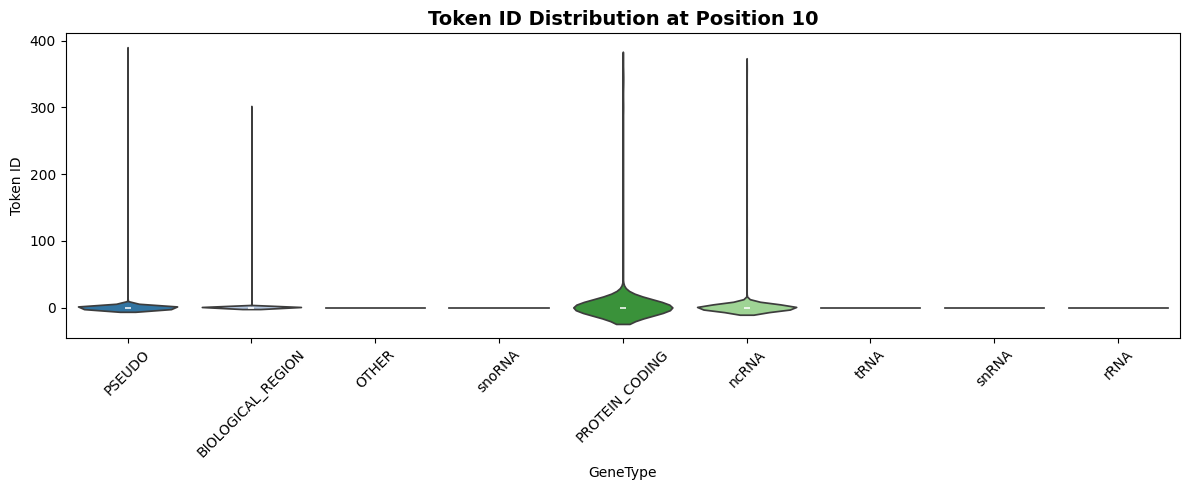

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


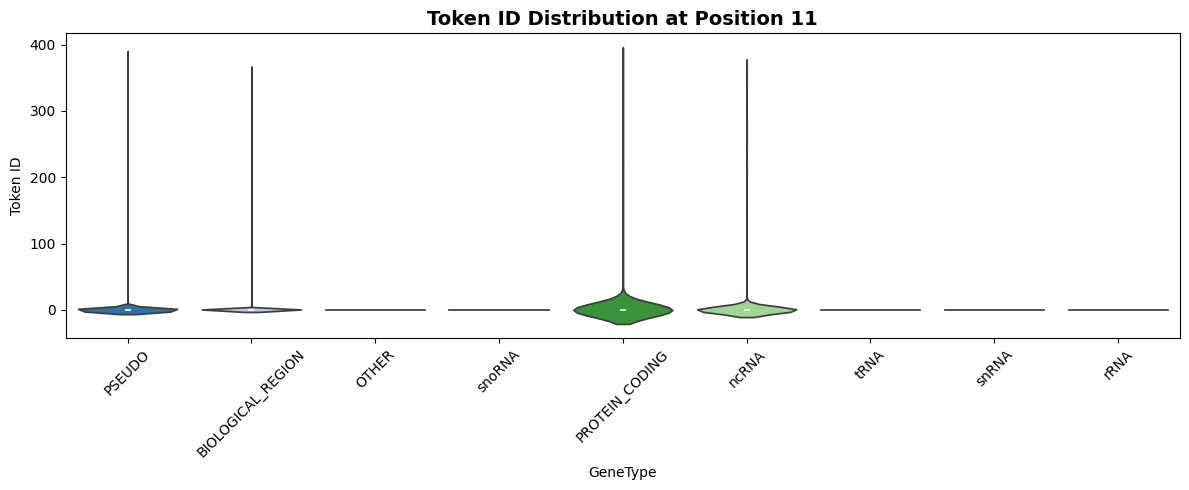

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


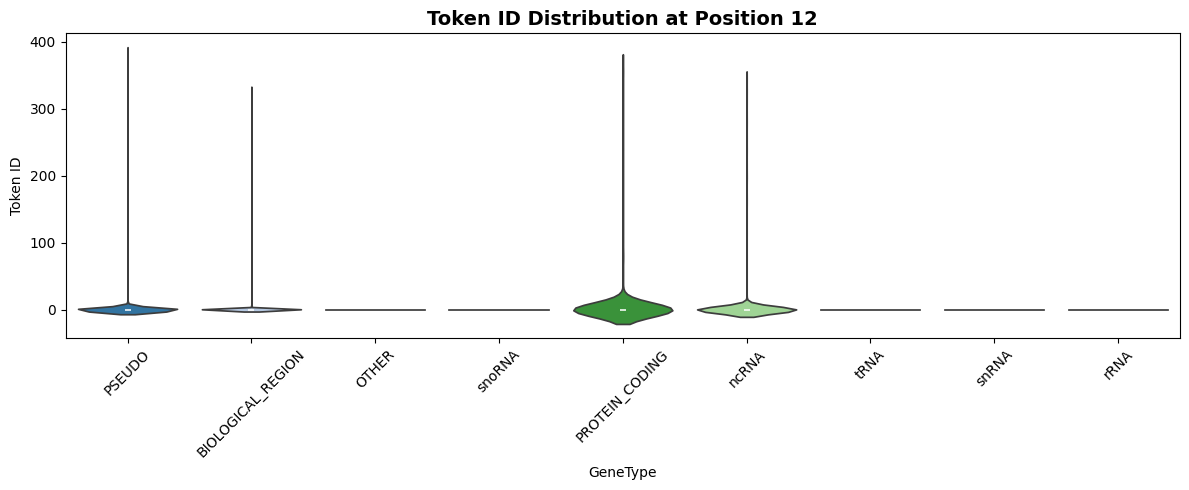

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


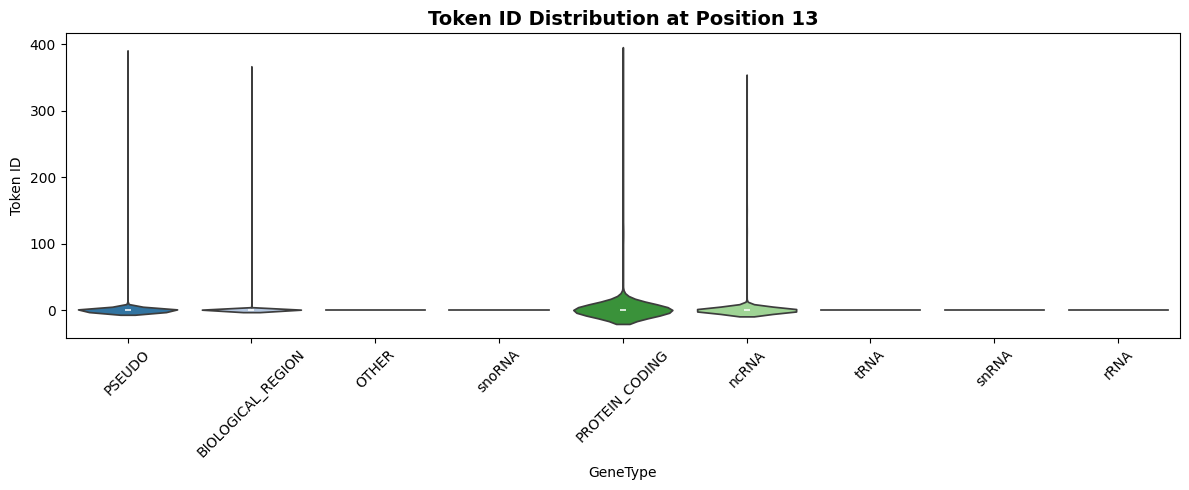

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


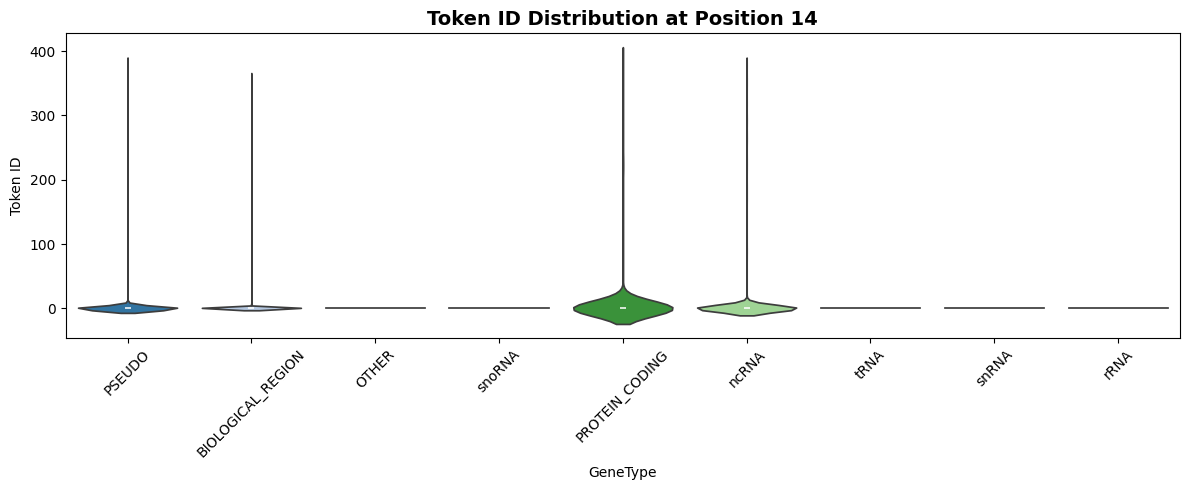

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


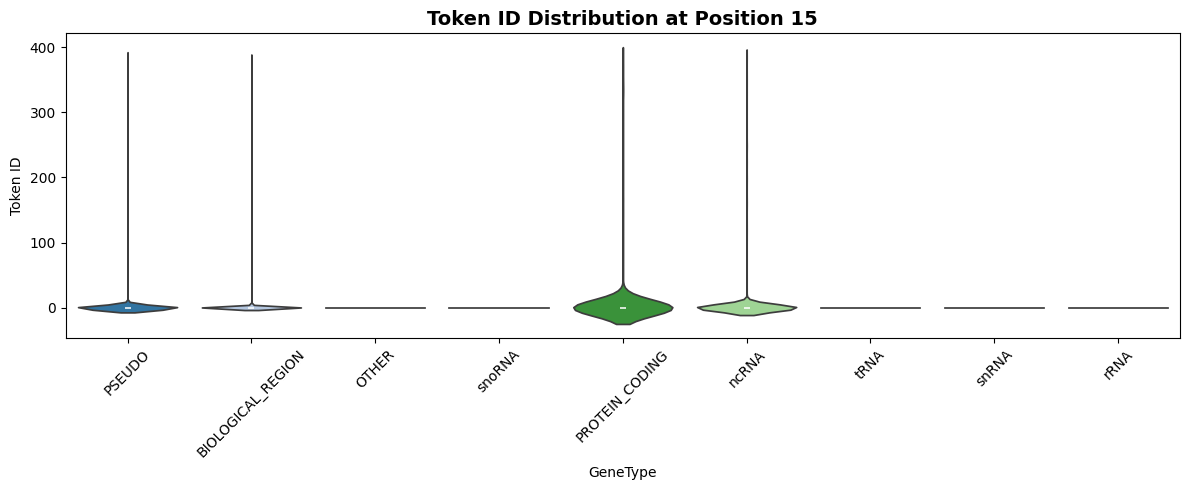

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


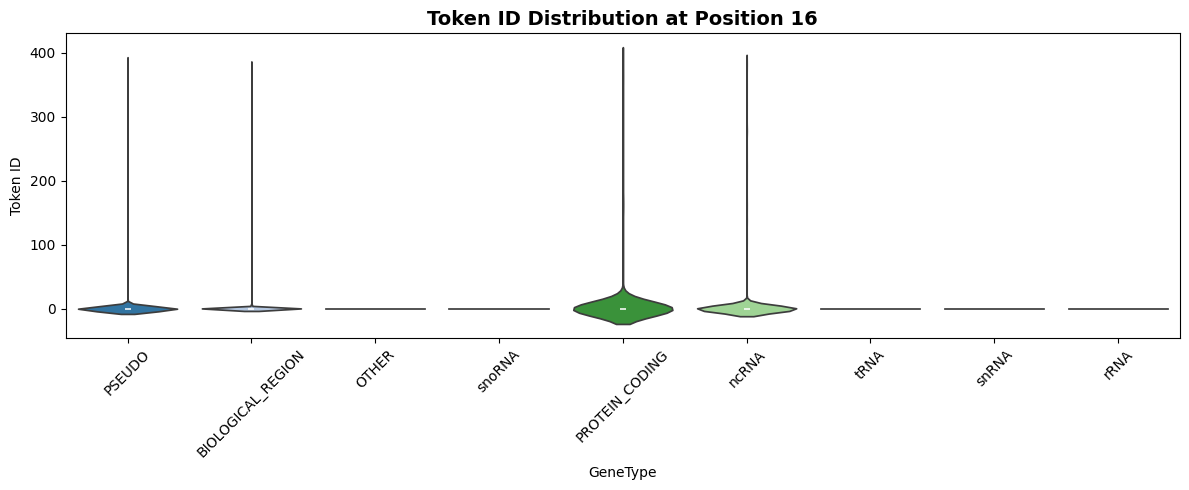

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


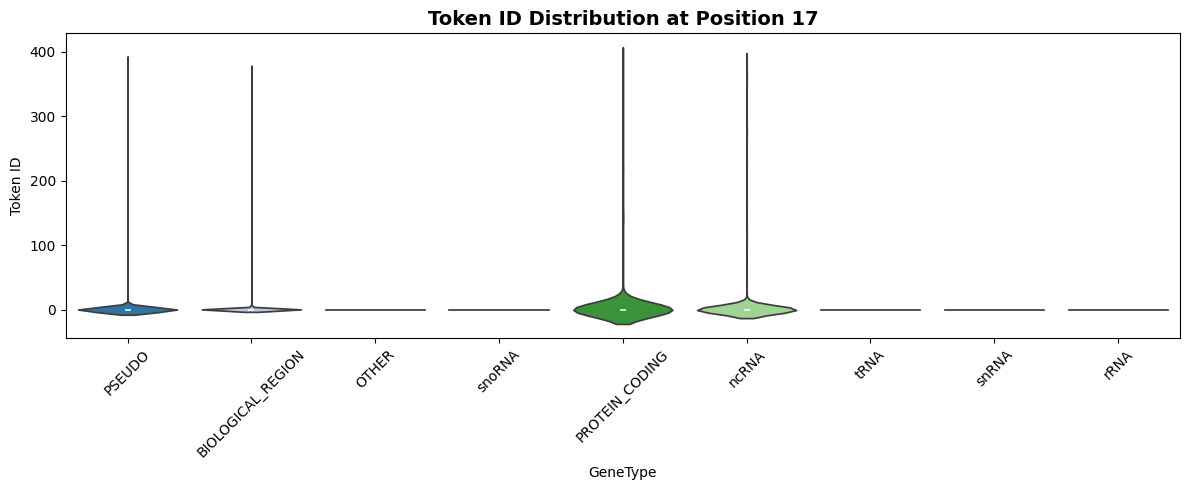

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


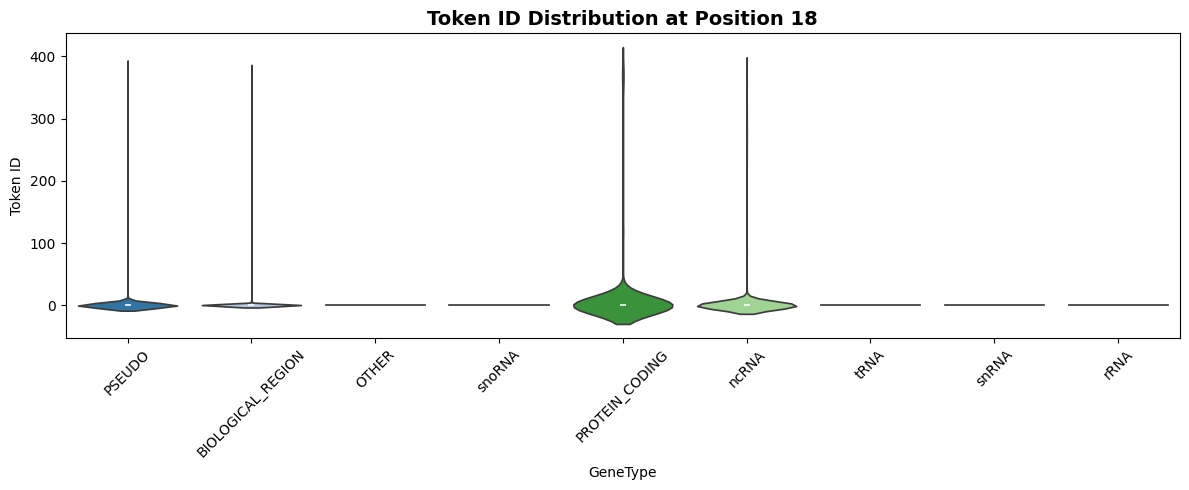

C:\Users\r\AppData\Local\Temp\ipykernel_28132\410294892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_long[df_long['Position'] == pos],


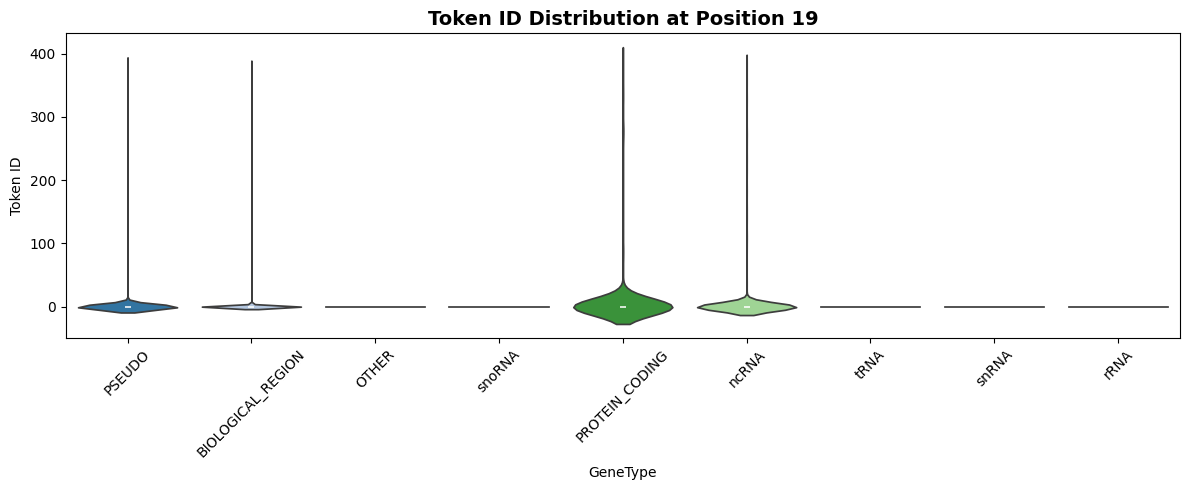

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

os.makedirs("results/feature_distributions_violin", exist_ok=True)

for pos in range(N):
    plt.figure(figsize=(12, 5))
    sns.violinplot(data=df_long[df_long['Position'] == pos],
                   x='GeneType', y='TokenID', palette='tab20', inner='box')
    plt.title(f'Token ID Distribution at Position {pos}', fontsize=14, fontweight='bold')
    plt.xlabel('GeneType')
    plt.ylabel('Token ID')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"results/feature_distributions_violin/violin_token_pos_{pos}.png")
    plt.show()
